In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'

import wrf

#import metpy.calc as mpcalc
#from metpy.plots import SkewT
#from metpy.units import units

# Functions, data

In [2]:
def extract_wrfout(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfpro(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfpout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

In [8]:
hrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')

In [9]:
hrchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')

In [10]:
hgt = hrchannel.HGT.isel(south_north=0,Time=-1).persist()
def plotsection(hgt):
    fig, ax = plt.subplots(1,1,figsize=(15,4))
    ax.set_xlabel("distance west of mountain top (km)")
    ax.set_ylabel("height(m)")
    ax.plot((1635-hgt.west_east)*3,hgt,color='k')
    return ax,ax.twinx()

In [11]:
def add_text(ax):
    ax.text(0.1, 0.1,'EAST (upstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")
    ax.text(0.9, 0.1,'WEST (downstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")

In [12]:
from wrf import cape_2d
import wrf
from netCDF4 import Dataset

def compute_individual_cape(file):
    return wrf.getvar(Dataset(file), "cape_2d", timeidx=wrf.ALL_TIMES)

In [13]:
#%%time
##Takes 1 hour
#capecin_list=[]
#for file in sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/wrfout*')):
#    print(file)
#    c = compute_individual_cape(file)
#    del(c.attrs['projection'])
#    c.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.cape.'+file[-19:]+'.nc')
    

In [14]:
def rad_cooling(sim):
    mSWUPT = (sim.ACSWUPT.isel(Time = -1)-sim.ACSWUPT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWDNT = (sim.ACSWDNT.isel(Time = -1)-sim.ACSWDNT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWUPB = (sim.ACSWUPB.isel(Time = -1)-sim.ACSWUPB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWDNB = (sim.ACSWDNB.isel(Time = -1)-sim.ACSWDNB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWUPT = (sim.ACLWUPT.isel(Time = -1)-sim.ACLWUPT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWDNT = (sim.ACLWDNT.isel(Time = -1)-sim.ACLWDNT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWUPB = (sim.ACLWUPB.isel(Time = -1)-sim.ACLWUPB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWDNB = (sim.ACLWDNB.isel(Time = -1)-sim.ACLWDNB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    return mSWUPT-mSWDNT-mSWUPB+mSWDNB+mLWUPT-mLWDNT-mLWUPB+mLWDNB

In [15]:
slices = [((-1000,0),"upstream 1000km"),
          ((0,1000),"downstream 1000km"),
          ((1000,2000),"1000-2000km downstream"),
          ((-4900,-1000),"far region (RCE)")
         ]

In [16]:
plevs=np.array([100000,97500,95000,92500,90000,87500,85000,82500,80000,77500,75000,70000,65000,60000,55000,50000,45000,40000,35000,30000,25000,22500,20000,17500,15000,12500,10000,7000,5000,1000])/100


In [17]:
umean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U_PL.days50-200.nc')
vmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.V_PL.days50-200.nc')
wmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W_PL.days50-200.nc')
rhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO_PL.days50-200.nc')
qmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.Q_PL.days50-200.nc')
tmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')
zmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.GHT_PL.days50-100.nc')


In [18]:
umean   = umean.where(umean > -100)  
vmean   = vmean.where(vmean > -100)  
wmean   = wmean.where(wmean > -100)  
rhomean = rhomean.where(rhomean >0.)  
qmean   = qmean.where(qmean >0.)  
tmean   = tmean.where(tmean >100.)  
omegamean = -9.81*rhomean*wmean

# Spinup

In [37]:
def plot_timeseries_diff2(simulation1,simulations,variable,ax,scale=None):
    initvar = simulation1[variable].mean('south_north')
    endvar  = simulation1[variable].isel(Time=slice(-40,-1)).mean(['south_north','Time']).persist()
    ax.plot(initvar.Time/4,np.sqrt(((initvar-endvar)**2).mean(initvar.dims[1:])),label='control')
    for i,sim in enumerate(simulations):
        initvar2 = sim[variable].mean('south_north')
        ax.plot(initvar2.Time/4,np.sqrt(((initvar2-endvar)**2).mean(initvar.dims[1:])),label='compared %i'%i)
    ax.set_title(simulation1[variable].description + " sqrt(mean sq diff), rel. to last 10 days")
    ax.set_xlabel('days')
    ax.legend()
    
def plot_timeseries_diff_rain2(simulation1,simulations,ax,scale=None):
    initvar = 4*(simulation1.RAINC+simulation1.RAINNC).diff('Time').mean('south_north').load()
    initvar_rolling = initvar.rolling(Time=40,center=True).mean()
    endvar  = 4*(simulation1.RAINC+simulation1.RAINNC).isel(Time=slice(-40,-1)).diff('Time').mean(['south_north','Time']).persist() #
    
    ax.plot(initvar.Time/4,np.sqrt(((initvar_rolling-endvar)**2).mean(initvar.dims[1:])),label='10 day rolling mean precip, control')
    for i,sim in enumerate(simulations):
        initvar2 = 4*(sim.RAINC+sim.RAINNC).diff('Time').mean('south_north').load()
        initvar2_rolling = initvar2.rolling(Time=40,center=True).mean()
        ax.plot(initvar2.Time/4,np.sqrt(((initvar2_rolling-endvar)**2).mean(initvar2.dims[1:])),label='10 day rolling mean precip, compared %i'%i)
    ax.set_title("precip, sqrt(mean sq diff), rel. to last 10 days")
    ax.set_xlabel('days')
    ax.legend()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 1min 13s, sys: 6min 13s, total: 7min 27s
Wall time: 7min 17s


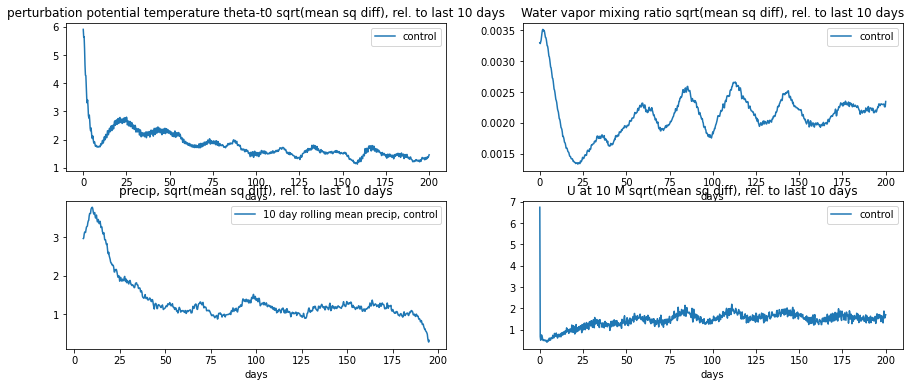

In [38]:
%%time
fig, ax = plt.subplots(2,2,figsize=(15,6))
ax=ax.reshape(-1)
plot_timeseries_diff2(     hrchannel,[],"T"     ,ax[0])
plot_timeseries_diff2(     hrchannel,[],"QVAPOR",ax[1])
plot_timeseries_diff2(     hrchannel,[],"U10"   ,ax[3])
plot_timeseries_diff_rain2(hrchannel,[]         ,ax[2])

CPU times: user 16.8 s, sys: 45.6 s, total: 1min 2s
Wall time: 50.7 s


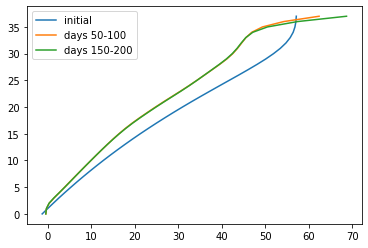

In [40]:
%%time
plt.plot(hrchannel.T.isel(Time=0).mean(['south_north','west_east']),hrchannel.bottom_top,label='initial')
plt.plot(hrchannel.T.isel(Time=slice(200,400)).mean(['south_north','west_east','Time']),hrchannel.bottom_top,label='days 50-100')
plt.plot(hrchannel.T.isel(Time=slice(600,800)).mean(['south_north','west_east','Time']),hrchannel.bottom_top,label='days 150-200')
plt.legend()

# Cross-sections

In [16]:
#%time hrchannelprecip = 4*(hrchannel.RAINC+hrchannel.RAINNC).diff('Time').persist()
#hrchannelprecip.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc')

CPU times: user 2.19 s, sys: 1min 34s, total: 1min 37s
Wall time: 2min 38s


In [19]:
hrchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc')

In [20]:
%time hrchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d

CPU times: user 523 ms, sys: 237 ms, total: 760 ms
Wall time: 3.12 s


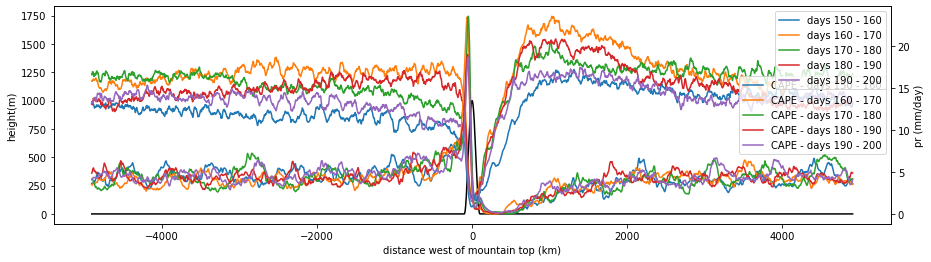

In [30]:
fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
dist=(1635-hgt.west_east)*3

ax.plot(dist,hgt,color='k')

for i in range(15,20):
    ax.plot(dist ,hrchannel_capecin[0].isel(Time=slice(40*i,40*(i+1))).mean(['south_north','Time']),label='CAPE - days %i - %i'%(10*i,10*(i+1)))



ax2=ax.twinx()
ax2.set_ylabel("pr (mm/day)")
for i in range(15,20):
    ax2.plot(dist ,hrchannelprecip.isel(Time=slice(40*i,40*(i+1))).mean(['south_north','Time']),label='days %i - %i'%(10*i,10*(i+1)))#,color='green',label='precipitation')
ax.legend(loc="center right")
ax2.legend()

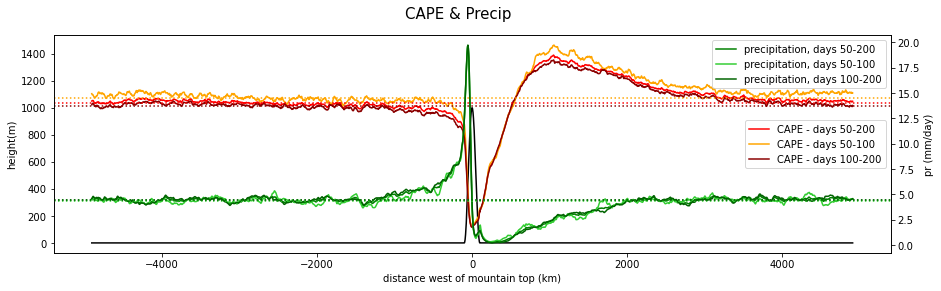

In [34]:
fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
dist=(1635-hgt.west_east)*3

ax.plot(dist,hgt,color='k')
ax.plot(dist ,hrchannel_capecin[0].isel(Time=slice(200,800)).mean(['south_north','Time']),label='CAPE - days 50-200',color='r')
ax.plot(dist ,hrchannel_capecin[0].isel(Time=slice(200,400)).mean(['south_north','Time']),label='CAPE - days 50-100',color='orange')
ax.plot(dist ,hrchannel_capecin[0].isel(Time=slice(400,800)).mean(['south_north','Time']),label='CAPE - days 100-200',color='darkred')

ax2=ax.twinx()
ax2.set_ylabel("pr (mm/day)")
ax2.plot(dist ,hrchannelprecip.isel(Time=slice(200,800)).mean(['south_north','Time']),color='green',label='precipitation, days 50-200')
ax2.plot(dist ,hrchannelprecip.isel(Time=slice(200,400)).mean(['south_north','Time']),color='limegreen',label='precipitation, days 50-100')
ax2.plot(dist ,hrchannelprecip.isel(Time=slice(400,800)).mean(['south_north','Time']),color='darkgreen',label='precipitation, days 100-200')

ax.legend(loc="center right")
ax2.legend()

ax.axhline(hrchannel_capecin[0].isel(Time=slice(200,800),west_east=slice(2000,3000)).mean(),color='r',linestyle=':')
ax2.axhline(hrchannelprecip.isel(Time=slice(200,800),west_east=slice(2000,3000)).mean(),color='g',linestyle=':')
fig.suptitle("CAPE & Precip", fontsize=15)

ax.axhline(hrchannel_capecin[0].isel(Time=slice(200,400),west_east=slice(2000,3000)).mean(),color='orange',linestyle=':')
ax2.axhline(hrchannelprecip.isel(Time=slice(200,400),west_east=slice(2000,3000)).mean(),color='limegreen',linestyle=':')

ax.axhline(hrchannel_capecin[0].isel(Time=slice(400,800),west_east=slice(2000,3000)).mean(),color='darkred',linestyle=':')
ax2.axhline(hrchannelprecip.isel(Time=slice(400,800),west_east=slice(2000,3000)).mean(),color='darkgreen',linestyle=':')

AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

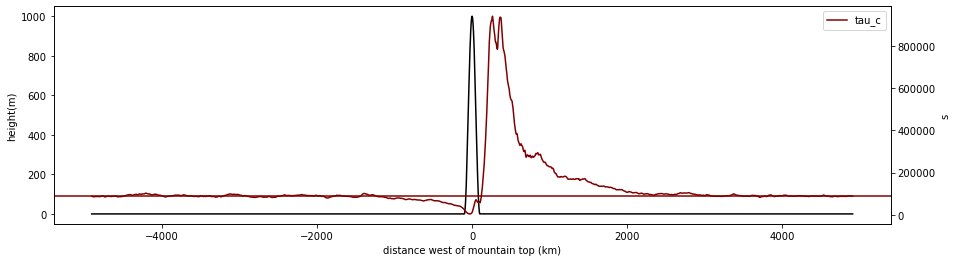

In [41]:
_,ax2=plotsection(hgt)
dist=(1635-hgt.west_east)*3
cape=hrchannel_capecin[0].isel(Time=slice(200,800)).mean(['south_north','Time'])
pr = hrchannelprecip.isel(Time=slice(200,800)).mean(['south_north','Time'])
tauc=cape/(2.26e6*pr/86400/10000)

ax2.plot(dist,tauc,color='maroon',label="tau_c")
ax2.set_ylabel("s")
ax2.legend()

ax2.axhline(tauc[2000:3000].mean(),color='maroon')
ax.set_title("Convective time scale", fontsize=15)

In [73]:
hrchannel_capecin_mean = hrchannel_capecin.isel(Time=slice(200,400)).mean(['Time','south_north']).persist()

Text(0.5, 1.0, 'CIN & LFC')

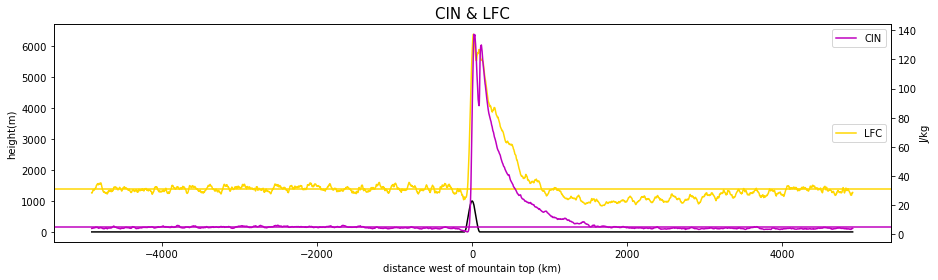

In [74]:
ax,ax2=plotsection(hgt)
dist=(1635-hgt.west_east)*3
ax.plot(dist,hrchannel_capecin_mean[3],color='gold',label="LFC")
ax2.set_ylabel("J/kg")
ax2.plot(dist,hrchannel_capecin_mean[1],color='m',label="CIN")
ax.legend(loc="center right")
ax2.legend()

ax.axhline( hrchannel_capecin_mean[3][2000:3000].mean(),color='gold')
ax2.axhline(hrchannel_capecin_mean[1][2000:3000].mean(),color='m')
ax.set_title("CIN & LFC", fontsize=15)

Text(0.5, 1.0, 'Evaporation')

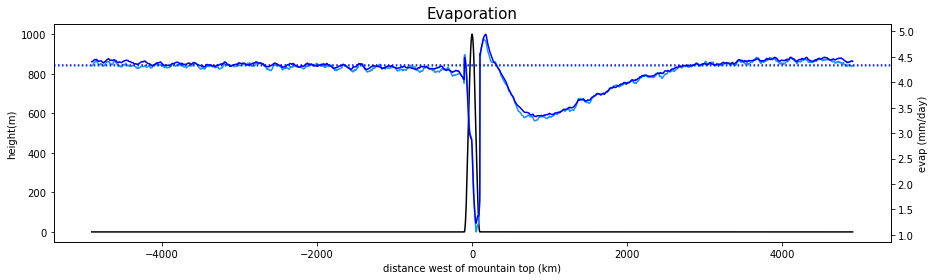

In [43]:
_,ax2 = plotsection(hgt)
dist=(1635-hgt.west_east)*3
ax2.set_ylabel("evap (mm/day)")
ax2.plot(dist,86400*hrchannel.QFX.isel(Time=slice(200,400)).mean(['south_north','Time']),color='dodgerblue')
ax2.axhline(86400*hrchannel.QFX.isel(Time=slice(200,400),west_east=slice(2000,3000)).mean(),color='dodgerblue',linestyle=':')

ax2.plot(dist,86400*hrchannel.QFX.isel(Time=slice(200,800)).mean(['south_north','Time']),color='blue')
ax2.axhline(86400*hrchannel.QFX.isel(Time=slice(200,800),west_east=slice(2000,3000)).mean(),color='blue',linestyle=':')

ax2.set_title("Evaporation", fontsize=15)


Text(0.5, 1.0, 'q_v at 2m')

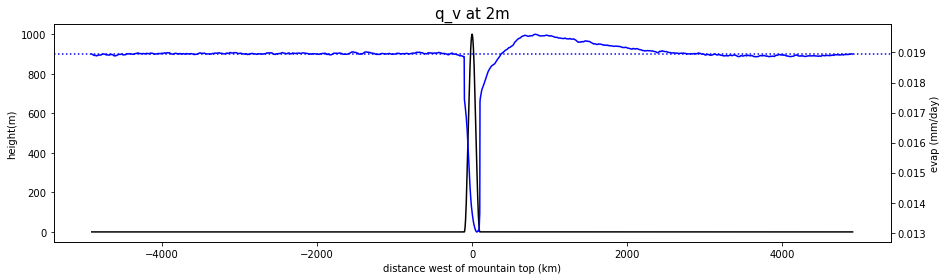

In [284]:
_,ax2 = plotsection(hgt)
dist=(1635-hgt.west_east)*3
ax2.set_ylabel("evap (mm/day)")
ax2.plot(dist,hrchannel.Q2.isel(Time=slice(200,400)).mean(['south_north','Time']),color='blue')
ax2.axhline(hrchannel.Q2.isel(Time=slice(200,400),west_east=slice(2000,3000)).mean(),color='blue',linestyle=':')

ax2.set_title("q_v at 2m", fontsize=15)


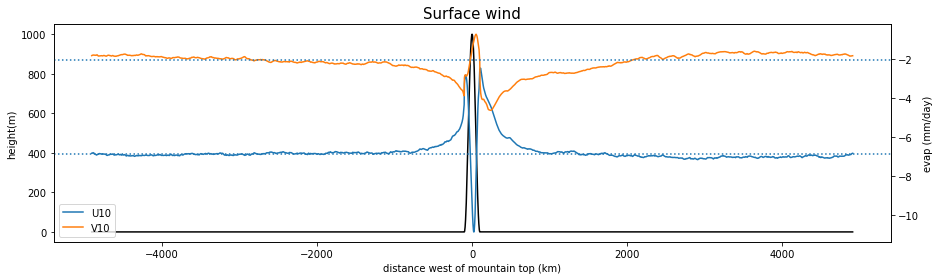

In [280]:
_,ax2 = plotsection(hgt)
dist=(1635-hgt.west_east)*3
ax2.set_ylabel("evap (mm/day)")
ax2.plot(dist,hrchannel.U10.isel(Time=slice(200,400)).mean(['south_north','Time']), label='U10')
ax2.axhline(hrchannel.U10.isel(Time=slice(200,400),west_east=slice(2000,3000)).mean(),linestyle=':')

ax2.plot(dist,hrchannel.V10.isel(Time=slice(200,400)).mean(['south_north','Time']), label='V10')
ax2.axhline(hrchannel.V10.isel(Time=slice(200,400),west_east=slice(2000,3000)).mean(),linestyle=':')

ax2.set_title("Surface wind", fontsize=15)
ax2.legend()


In [48]:
R = rad_cooling(hrchannel.isel(Time=slice(200,400))).mean(['south_north']).persist()

In [49]:
# Mass-weighted mean radiative cooling (note this is not perfect, because just averaged over instantaneous values of radiative cooling, only output every 6 hours).
Cp=1004.
P_W = np.interp(hrchannel.ZNW.isel(Time=0)[::-1],hrchannel.ZNU.isel(Time=0)[::-1],hrchannel.PB[0,::-1,0,0])[::-1]
mass = xr.DataArray((P_W[:-1]-P_W[1:])/9.81,coords=hrchannel.PB[0,::-1,0,0].coords)
RTHRATENhat=(Cp*mass*hrchannel.RTHRATEN.isel(Time=slice(200,400)).mean(['Time','south_north'])).sum('bottom_top').persist()
RTHRATEN=hrchannel.RTHRATEN.isel(Time=slice(200,400)).mean(['Time','south_north','west_east']).persist()


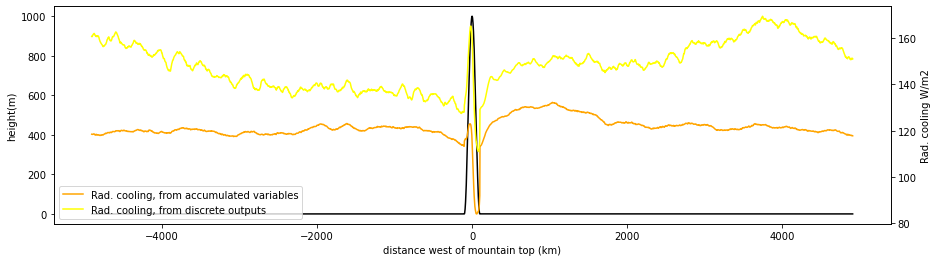

In [60]:
_,ax2 = plotsection(hgt)
dist=(1635-hgt.west_east)*3
ax2.set_ylabel("Rad. cooling W/m2")
ax2.plot(dist,R,color='orange',label="Rad. cooling, from accumulated variables")
ax2.plot(dist,-RTHRATENhat,color='yellow',label="Rad. cooling, from discrete outputs")
ax2.legend()

No handles with labels found to put in legend.


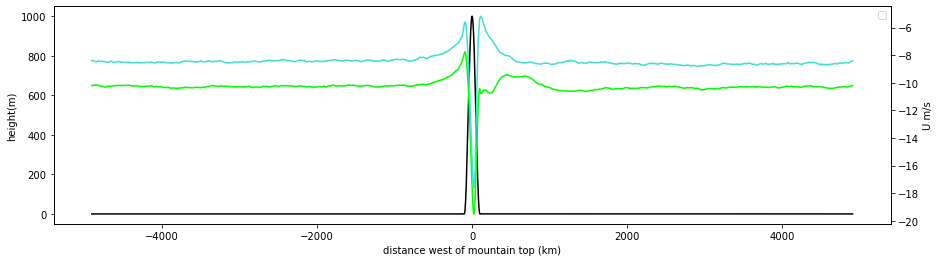

In [178]:
_,ax2 = plotsection(hgt)
dist=(1635-hgt.west_east)*3
ax2.set_ylabel("U m/s")
ax2.plot(dist,hrchannel.U.isel(Time=slice(200,400),bottom_top=3).mean(['south_north','Time'])[:-1],color='lime')
#ax2.axhline(hrchannel.U.isel(Time=slice(200,400),bottom_top=3,west_east_stag=slice(2000,3000)).mean(),color='lime',linestyle=':')

ax2.plot(dist,hrchannel.U.isel(Time=slice(200,400),bottom_top=1).mean(['south_north','Time'])[:-1],color='turquoise')

ax2.legend()

In [12]:
CLDFRA=hrchannel.CLDFRA.isel(Time=slice(200,400)).mean(['Time','south_north','west_east']).persist()


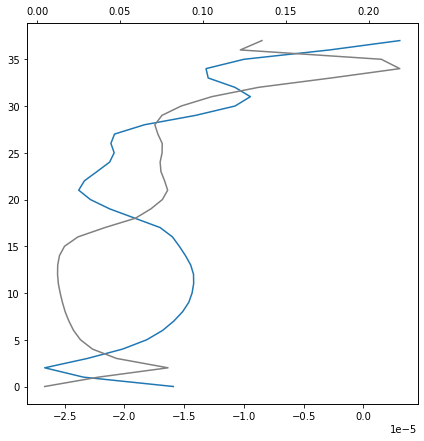

In [14]:
_,ax=plt.subplots(1,1,figsize=(7,7))
ax.plot(RTHRATEN,RTHRATEN.bottom_top)
ax2=ax.twiny()
ax2.plot(CLDFRA,CLDFRA.bottom_top,color="grey")

# Soundings

In [13]:
%time wmean=hrchannel_p.W_PL.isel(Time=slice(800,4801)).mean(['Time','south_north']).persist()
%time rhomean=hrchannel_p.RHO_PL.isel(Time=slice(800,4801)).mean(['Time','south_north']).persist()
%time tmean=hrchannel_p.T_PL.isel(Time=slice(800,4801)).mean(['Time','south_north']).persist()
%time qmean=hrchannel_p.Q_PL.isel(Time=slice(800,4801)).mean(['Time','south_north']).persist()
wmean.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W_PL.days50-200.nc')
rhomean.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO_PL.days50-200.nc')
tmean.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')
qmean.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.Q_PL.days50-200.nc')

CPU times: user 2min 20s, sys: 9min 50s, total: 12min 10s
Wall time: 9min 25s
CPU times: user 2min 10s, sys: 10min 23s, total: 12min 34s
Wall time: 9min 46s
CPU times: user 2min 19s, sys: 10min 25s, total: 12min 44s
Wall time: 12min 50s
CPU times: user 2min 16s, sys: 10min 43s, total: 12min 59s
Wall time: 9min 57s


In [ ]:
%time umean=hrchannel_p.U_PL.isel(Time=slice(800,4801)).mean(['Time','south_north']).persist()
%time vmean=hrchannel_p.V_PL.isel(Time=slice(800,4801)).mean(['Time','south_north']).persist()
umean.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U_PL.days50-200.nc')
vmean.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.V_PL.days50-200.nc')


CPU times: user 2min 32s, sys: 14min 31s, total: 17min 3s
Wall time: 11min 35s


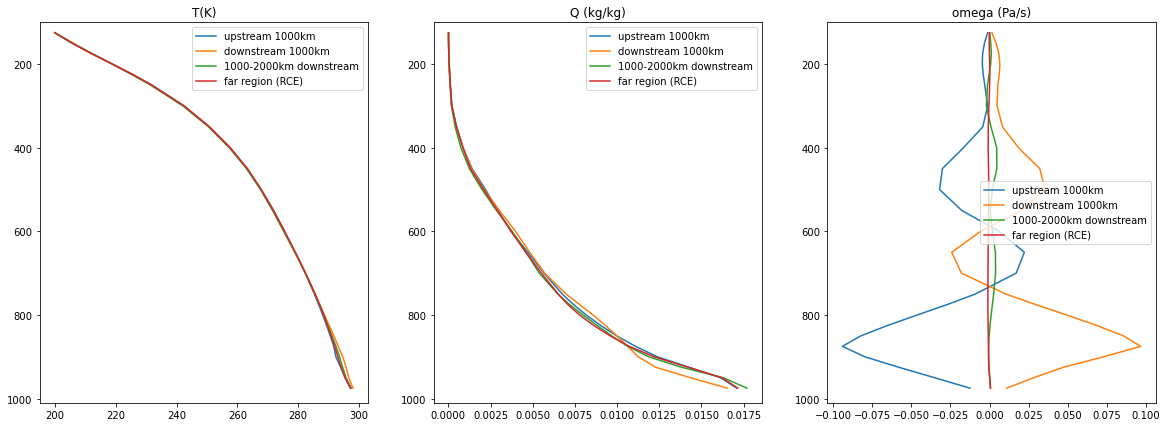

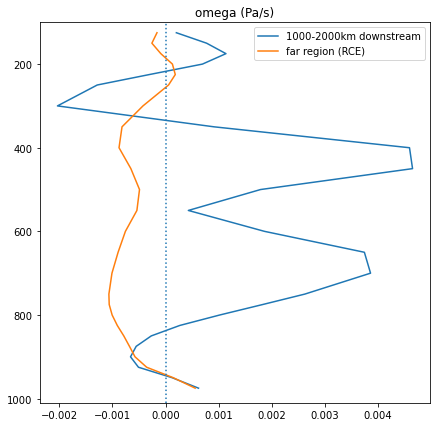

In [286]:

fig, ax = plt.subplots(1,3,figsize=(20,7))
with warnings.catch_warnings():
    warnings.simplefilter("ignore",RuntimeWarning)
    for j,(var,varname) in enumerate(zip([tmean,qmean,omegamean],("T(K)","Q (kg/kg)","omega (Pa/s)"))):
        for s,lbl in slices:
            s0,s1 = 1635-s[0]//3,1635-s[1]//3
            ax[j].plot(var.isel(west_east=slice(s1,s0)).mean("west_east"),plevs,label=lbl)
        ax[j].set_title(varname)
        ax[j].set_ylim(1010,100)
        ax[j].legend()
        
fig, ax = plt.subplots(1,1,figsize=(7,7))
with warnings.catch_warnings():
    warnings.simplefilter("ignore",RuntimeWarning)
    var=omegamean
    varname = "omega (Pa/s)"
    for s,lbl in slices[2:]:
        s0,s1 = 1635-s[0]//3,1635-s[1]//3
        ax.plot(var.isel(west_east=slice(s1,s0)).mean("west_east"),plevs,label=lbl)
    ax.set_title(varname)
    ax.set_ylim(1010,100)
    ax.legend()
    ax.axvline(0.,linestyle=':')

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/plots/skewt.py:131: MatplotlibDeprecationWarning: 
The 'label' parameter of __init__() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. If any parameter follows 'label', they should be passed as keyword, not positionally.
  return SkewXTick(self.axes, None, '', major=major)


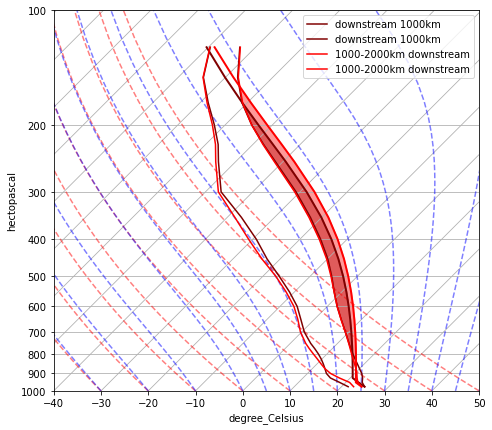

In [290]:
def plot_skewt(T,q,plevs,skew,color,lbl):
    P = plevs* units.hPa
    i=0
    Tups = units.degK*np.array(T)
    qups = np.array(q)

    #P=P[::-1]
    #Tups=Tups[::-1]
    #qups=qups[::-1]

    skew.plot(P, Tups,color=color ,label=lbl)
    
    Tdups = mpcalc.dewpoint_from_specific_humidity(qups,Tups,P)
    #Calculate full parcel profile and add to plot as black line
    capes=np.array([float(mpcalc.cape_cin(P[i:], Tups[i:], Tdups[i:],mpcalc.parcel_profile(P[i:], Tups[i], Tdups[i]).to('degC'))[0]/units("J/kg")) for i in range(len(Tups))])
    maxcape = np.argmax(capes)

    profups = mpcalc.parcel_profile(P[maxcape:], Tups[maxcape], Tdups[maxcape]).to('degC')
    skew.plot(P[maxcape:], profups, color=color, linewidth=2)
    skew.shade_cape(P[maxcape:], Tups[maxcape:], profups,color=color)
    
    skew.plot(P, Tdups,color=color ,label=lbl)
    
fig = plt.figure(figsize=(10,7))
skew = SkewT(fig, rotation=45)

s,lbl=slices[1]
plot_skewt(tmean.isel(west_east=slice(1635-s[1]//3,1635-s[0]//3)).mean("west_east")[1:-4],qmean.isel(west_east=slice(1635-s[1]//3,1635-s[0]//3)).mean("west_east")[1:-4],plevs[1:-4],skew,"maroon",lbl)
s,lbl=slices[2]
plot_skewt(tmean.isel(west_east=slice(1635-s[1]//3,1635-s[0]//3)).mean("west_east")[1:-4],qmean.isel(west_east=slice(1635-s[1]//3,1635-s[0]//3)).mean("west_east")[1:-4],plevs[1:-4],skew,"red",lbl)


skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 50)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
plt.legend()
#fig.suptitle(title + " || upstream CAPE = %.1f J/kg, downstream = %.1f J/kg"%(mpcalc.cape_cin(P, Tups, Tdups,profups)[0]/units("J/kg"),mpcalc.cape_cin(P, Tdws, Tddws,profdws)[0]/units("J/kg")),fontsize=20)


# Winds, days 50-100

CPU times: user 5.11 s, sys: 9.51 s, total: 14.6 s
Wall time: 19.2 s


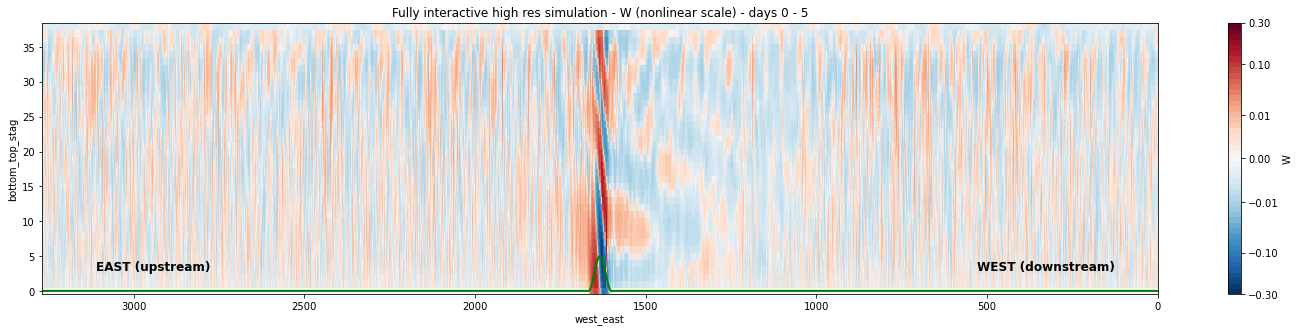

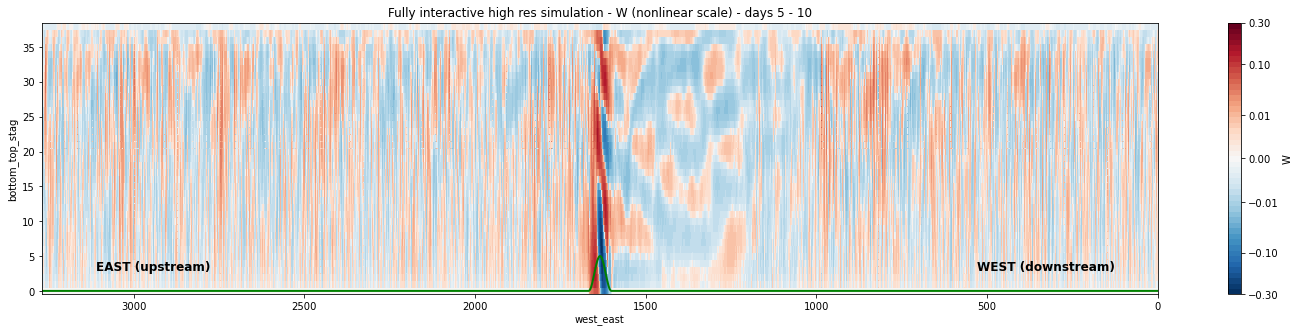

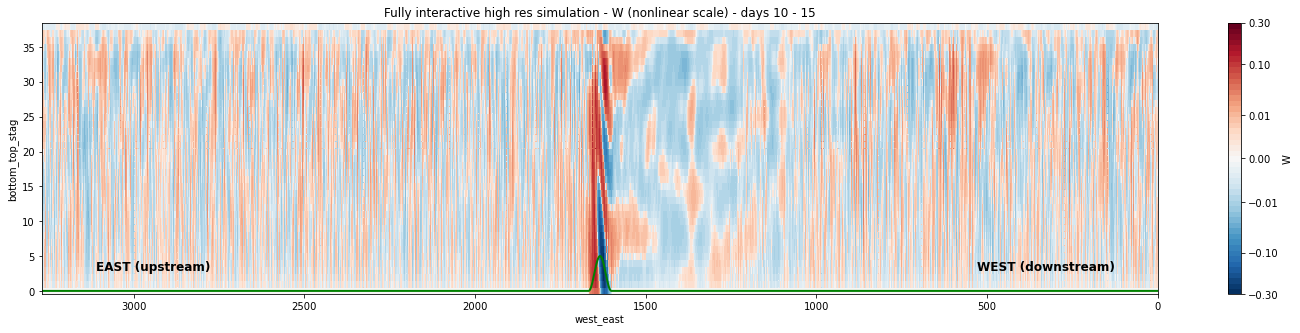

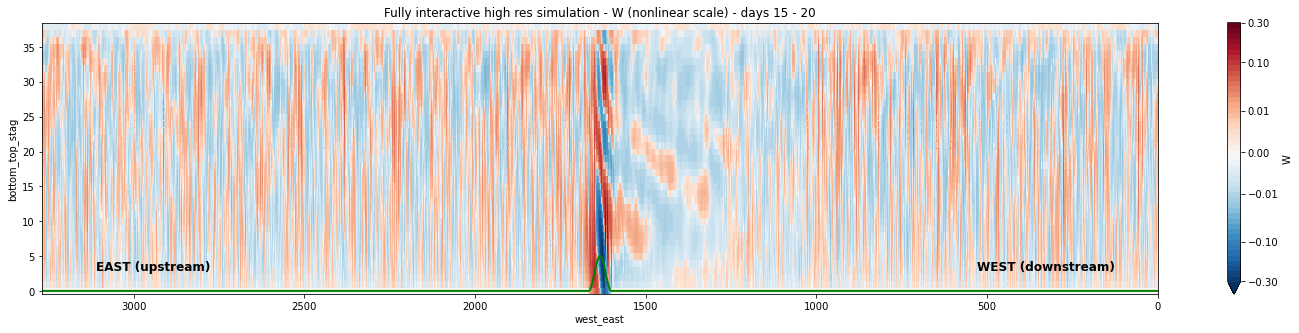

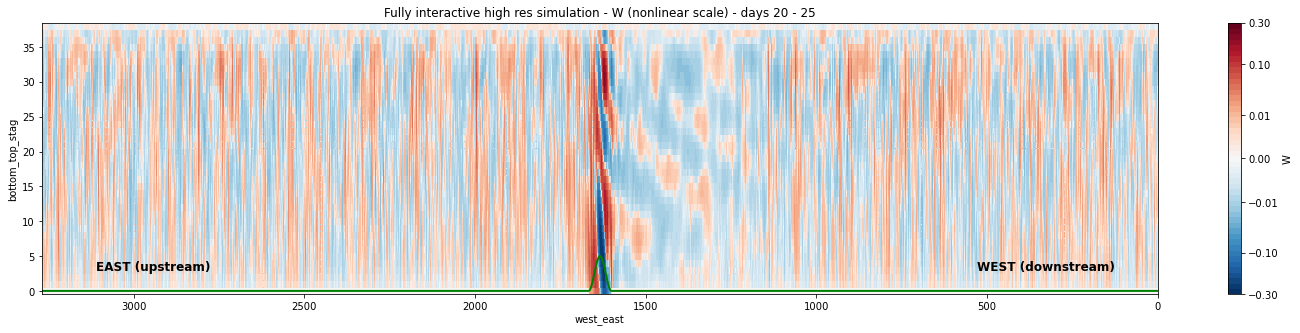

In [9]:
%%time
w_spinup=[]
for i in range(5):
    w_spinup.append(hrchannel.W.isel(Time=slice(5*4*i,5*4*(i+1))).mean(["Time","south_north"]).persist())
    _,ax=plt.subplots(1,1,figsize=(25,5))
    w_spinup[-1].plot(ax=ax, x='west_east',xincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
    ax.plot(hrchannel.west_east, hgt[::-1]/200,color='g',linewidth=2)
    add_text(ax)
    ax.set_title("Fully interactive high res simulation - W (nonlinear scale) - days %i - %i"%(5*i,5*(i+1)))

In [42]:
%%time
u = hrchannel.U.isel(Time=slice(200,800)).mean(["Time","south_north"]).persist()
v = hrchannel.V.isel(Time=slice(200,800)).mean(["Time","south_north_stag"]).persist()
w = hrchannel.W.isel(Time=slice(200,800)).mean(["Time","south_north"]).persist()
u.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U.days50-200.nc')
v.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.V.days50-200.nc')
w.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W.days50-200.nc')

CPU times: user 1min 10s, sys: 3min 41s, total: 4min 52s
Wall time: 4min 15s


In [278]:
u=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U.days50-200.nc')
v=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.V.days50-200.nc')
w=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W.days50-200.nc')

(1750.0, 1100.0)

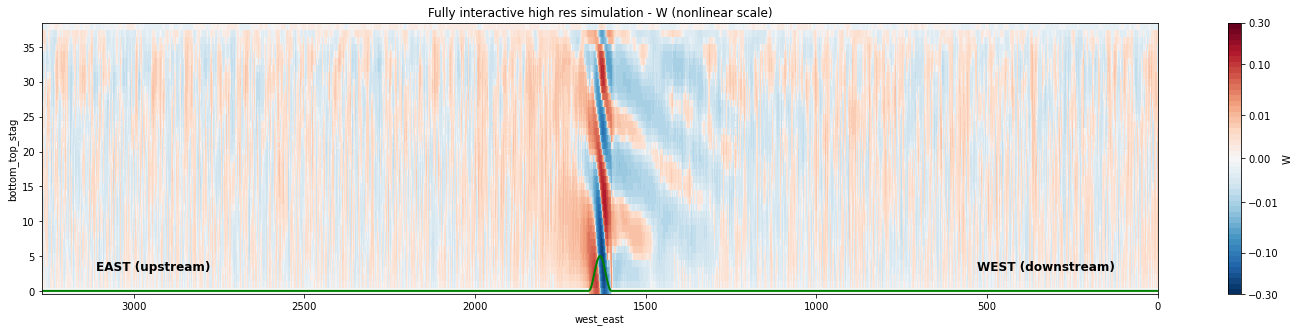

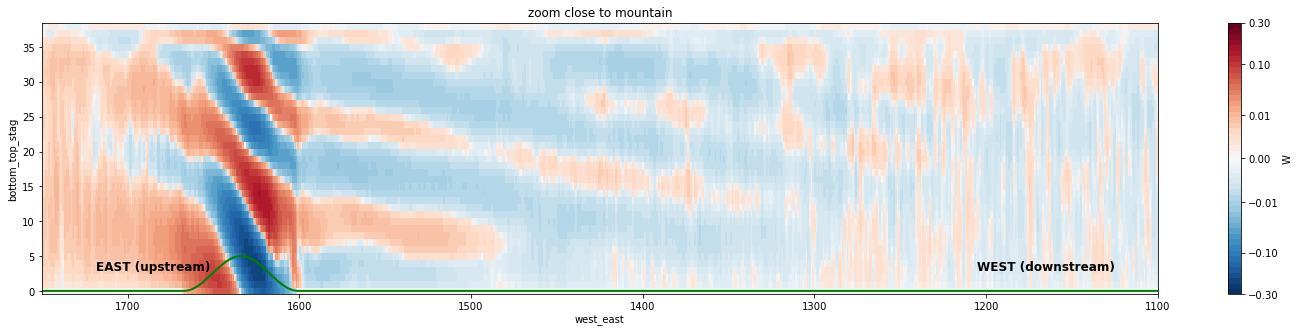

In [35]:
_,ax=plt.subplots(1,1,figsize=(25,5))
w.plot(ax=ax, x='west_east',xincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hrchannel.west_east, hgt[::-1]/200,color='g',linewidth=2)
add_text(ax)
ax.set_title("Fully interactive high res simulation - W (nonlinear scale)")

_,ax=plt.subplots(1,1,figsize=(25,5))
w.plot(ax=ax, x='west_east',xincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hrchannel.west_east, hgt[::-1]/200,color='g',linewidth=2)
add_text(ax)
ax.set_title("zoom close to mountain")
ax.set_xlim(1750,1100)

(1750.0, 1100.0)

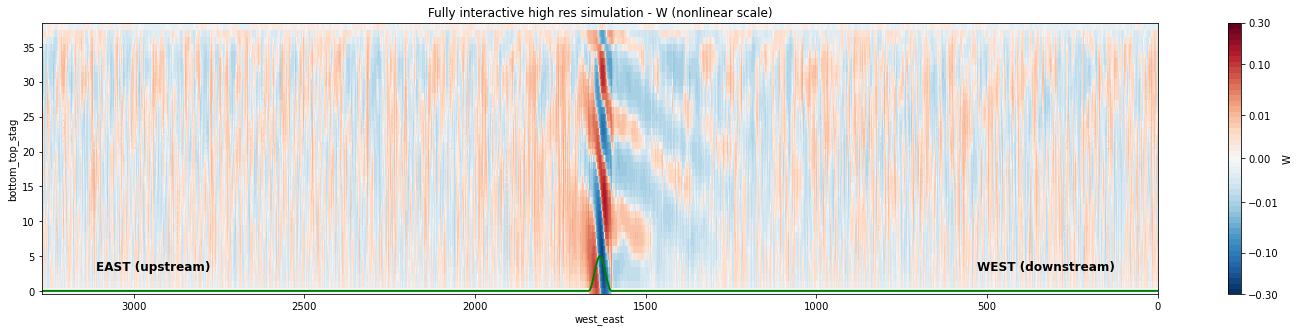

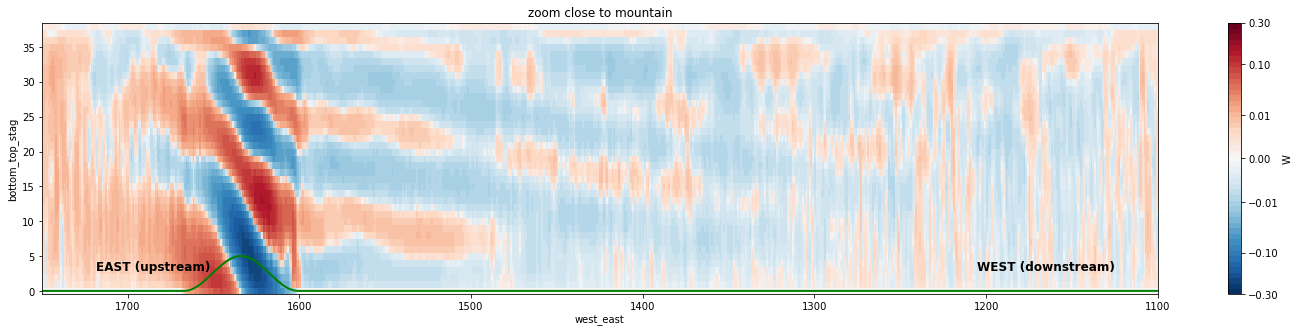

In [48]:
_,ax=plt.subplots(1,1,figsize=(25,5))
w.plot(ax=ax, x='west_east',xincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hrchannel.west_east, hgt[::-1]/200,color='g',linewidth=2)
add_text(ax)
ax.set_title("Fully interactive high res simulation - W (nonlinear scale)")

_,ax=plt.subplots(1,1,figsize=(25,5))
w.plot(ax=ax, x='west_east',xincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hrchannel.west_east, hgt[::-1]/200,color='g',linewidth=2)
add_text(ax)
ax.set_title("zoom close to mountain")
ax.set_xlim(1750,1100)

Text(0.5, 1.0, 'Fully interactive high res simulation - V')

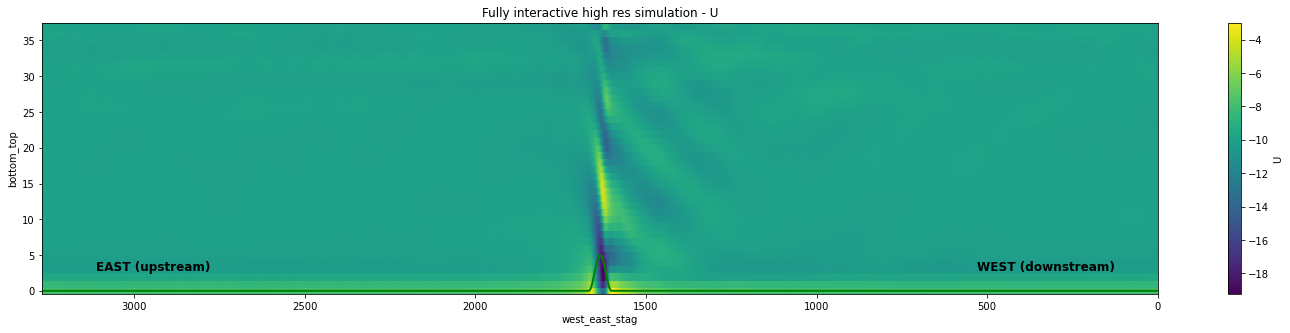

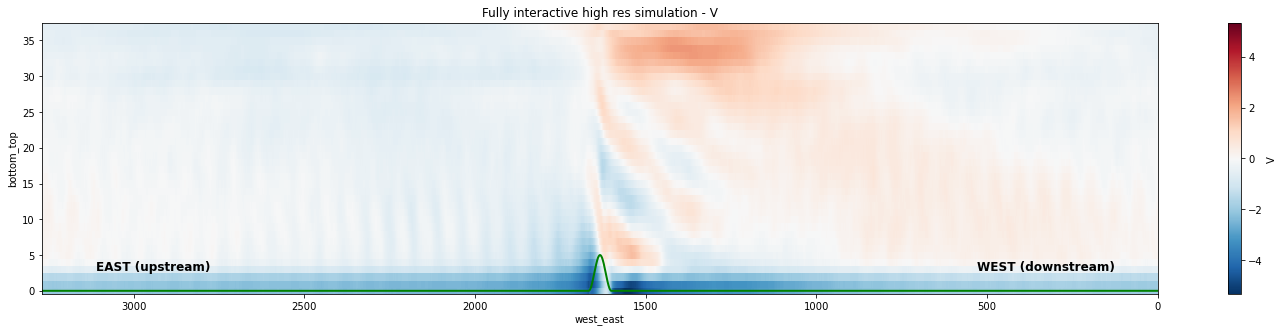

In [36]:
_,ax=plt.subplots(1,1,figsize=(25,5))
u.plot(ax=ax, x='west_east_stag',xincrease=False)#, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hrchannel.west_east, hgt[::-1]/200,color='g',linewidth=2)
add_text(ax)
ax.set_title("Fully interactive high res simulation - U")

_,ax=plt.subplots(1,1,figsize=(25,5))
v.plot(ax=ax, x='west_east',xincrease=False)#, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hrchannel.west_east, hgt[::-1]/200,color='g',linewidth=2)
add_text(ax)
ax.set_title("Fully interactive high res simulation - V")


# Precip CDF & composites over rainy events

In [279]:
%time dailymtnprecip = (hrchannel.RAINC+hrchannel.RAINNC)[::4].sel(west_east=slice(1600,1700)).diff('Time').mean(['south_north','west_east']).persist()

CPU times: user 812 ms, sys: 39.6 s, total: 40.4 s
Wall time: 1min


In [280]:
mtnprecip = hrchannelprecip.sel(west_east=slice(1600,1700)).mean(['south_north','west_east']).persist()

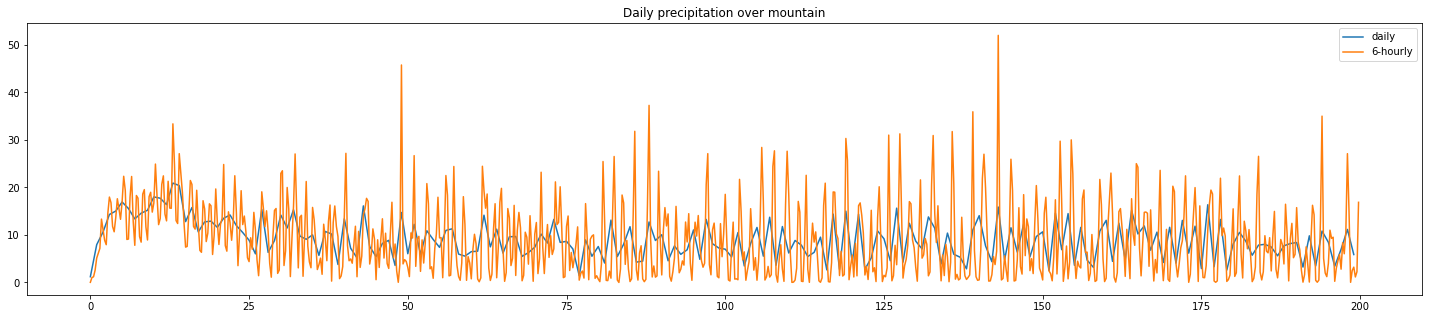

In [43]:
fig,ax=plt.subplots(1,1,figsize=(25,5))
ax.plot(dailymtnprecip,label='daily')
ax.plot(np.arange(0,200,0.25),mtnprecip,label='6-hourly')
#ax.plot(mtnprecip[::4],label='6pm-12am')
#ax.plot(mtnprecip[1::4],label='12am-6am')
#ax.plot(mtnprecip[2::4],label='6am-12pm')
#ax.plot(mtnprecip[3::4],label='12pm-6pm')
ax.set_title("Daily precipitation over mountain")
ax.legend()   

In [78]:
def plot_cdf(pr,ax,lbl=None):
    pctiles=100*np.concatenate([(1-10.**(-i+1))+10.**(-i)*np.arange(1,10,1) for i in range(1,4)])
    pctages = [float((100*pr.where(pr>float(pr.quantile(pctile/100,"Time"))).sum()/pr.sum())) for pctile in pctiles]
    ax.plot(pctiles/100,pctages,'-x',label=lbl)
    ax.legend()
    ax.set_xscale('logit')
    ax.set_xticks([0.1,0.5,0.9,0.99,0.999])
    ax.set_xticklabels([0.1,0.5,0.9,0.99,0.999])  
    ax.set_title("Cumulative fraction of total precipitation by percentile",fontsize=20)
    ax.set_xlabel("Percentile")
    ax.set_ylabel("Precip fraction")
    ax.grid()

CPU times: user 292 ms, sys: 20.9 ms, total: 313 ms
Wall time: 309 ms


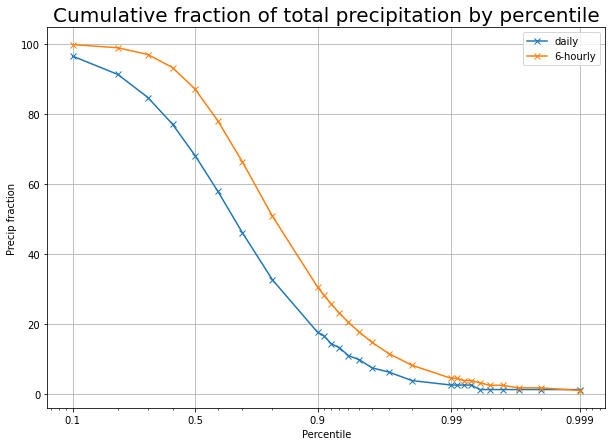

In [79]:
%%time
fig,ax=plt.subplots(1,1,figsize=(10,7))

plot_cdf(dailymtnprecip.isel(Time=slice(50,200)).load(),ax,'daily')
plot_cdf(mtnprecip.isel(Time=slice(200,800)).load(),ax,'6-hourly')

ax.grid()

In [281]:
%%time
pr= mtnprecip.isel(Time=slice(200,800)).load()
w_50 = hrchannel.W.isel(Time=slice(200,800)).where(pr>float(pr.quantile(0.5,"Time"))).mean(["Time","south_north"]).persist()

CPU times: user 36.1 s, sys: 2min 22s, total: 2min 58s
Wall time: 1min 59s


In [282]:
%time w_90 = hrchannel.W.isel(Time=slice(200,800)).where(pr>float(pr.quantile(0.9,"Time"))).mean(["Time","south_north"]).persist()

CPU times: user 38.6 s, sys: 2min 17s, total: 2min 56s
Wall time: 1min 54s


(2000.0, 1100.0)

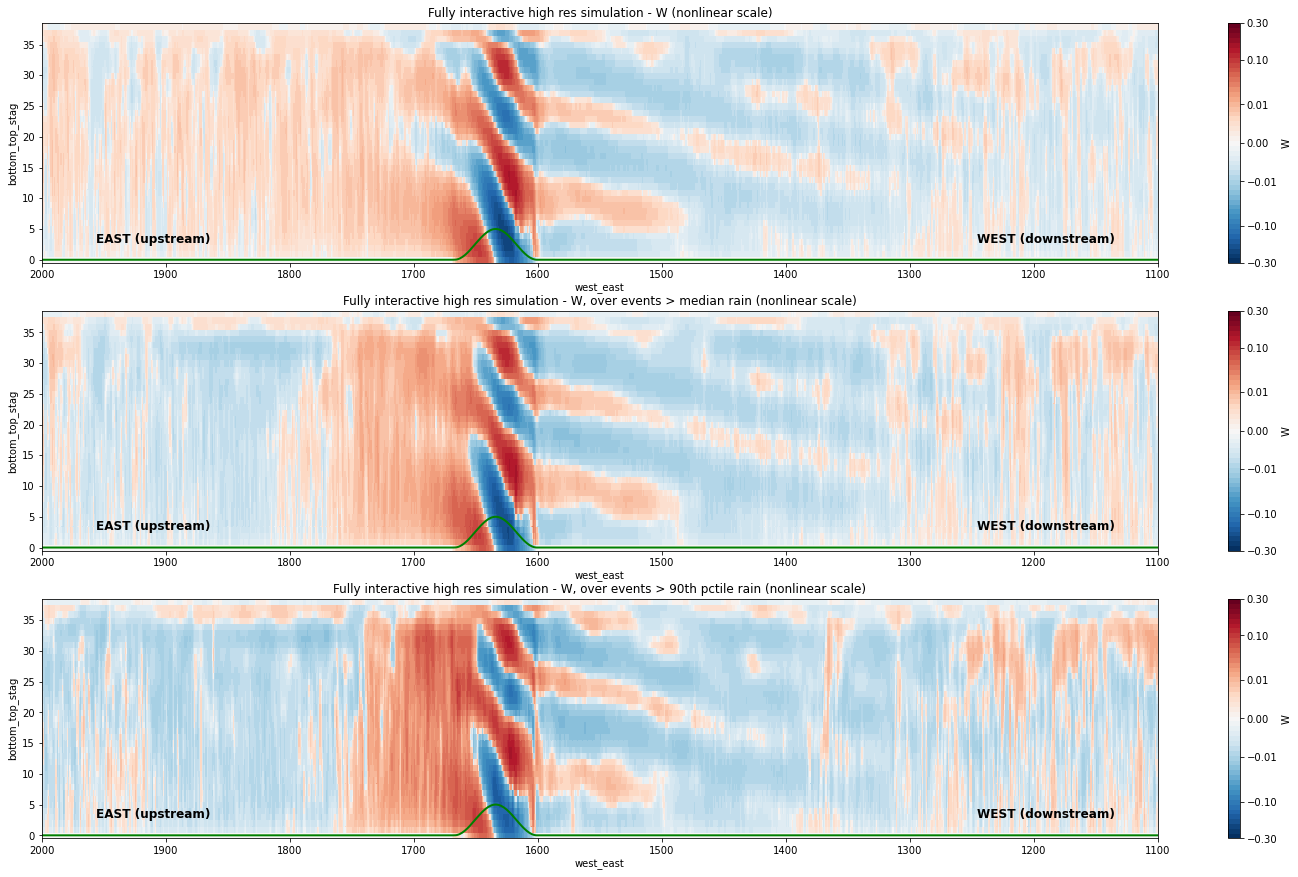

In [283]:
_,axx=plt.subplots(3,1,figsize=(25,15))
ax=axx[0]
w.plot(ax=ax, x='west_east',xincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hrchannel.west_east, hgt[::-1]/200,color='g',linewidth=2)
add_text(ax)
ax.set_title("Fully interactive high res simulation - W (nonlinear scale)")
ax.set_xlim(2000,1100)

ax=axx[1]
w_50.plot(ax=ax, x='west_east',xincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hrchannel.west_east, hgt[::-1]/200,color='g',linewidth=2)
add_text(ax)
ax.set_title("Fully interactive high res simulation - W, over events > median rain (nonlinear scale)")
ax.set_xlim(2000,1100)

ax=axx[2]
w_90.plot(ax=ax, x='west_east',xincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hrchannel.west_east, hgt[::-1]/200,color='g',linewidth=2)
add_text(ax)
ax.set_title("Fully interactive high res simulation - W, over events > 90th pctile rain (nonlinear scale)")
ax.set_xlim(2000,1100)

# Thermodynamic equation breakdown

In [38]:
def select(ds):
    return ds.isel(Time=slice(200,300),west_east=slice(1000,2500))
def select_stag(ds):
    return ds.isel(Time=slice(200,300),west_east_stag=slice(1000,2501))
def select_vstag(ds):
    return ds.isel(Time=slice(200,300),west_east=slice(1000,2500))
def select_time(ds):
    return ds.isel(Time=slice(200,300))

In [16]:
def interp_pressure_to_be_vectorized(var):
    """var must be destaggered"""
    plevs=np.array(hrchannel_p.P_PL.isel(Time=0).load())[1:-4]/100
    return wrf.vinterp(Dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/wrfout_d01_1970-02-20_06_00_00'),
                         var,"pressure",plevs
                        )

def interp_pressure_wtime(var):
    return xr.apply_ufunc(interp_pressure_to_be_vectorized,var,input_core_dims=[['bottom_top','south_north','west_east']],output_core_dims=[['interp_level','south_north','west_east']],vectorize=True,dask='parallelized',output_dtypes=float,dask_gufunc_kwargs={'output_sizes':{"interp_level":25,"south_north":66,"west_east":3270}}).rename({'interp_level':'pressure'}).fillna(0.)


def interp_pressure(var):
    """var must be destaggered"""
    plevs=np.array(hrchannel_p.P_PL.isel(Time=0).load())[1:-4]/100
    return wrf.vinterp(Dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/wrfout_d01_1970-02-20_06_00_00'),
                         var,"pressure",plevs
                        ).rename({'interp_level':'pressure'}).fillna(0.)

## Old calculation (on eta levels)

### 6-hourly

In [284]:
%%time
# Tendency term
dThetadt = select(hrchannel.T).chunk({'Time':-1,'south_north':11,'west_east':15}).differentiate('Time').persist()*4 #in K/day


CPU times: user 7.12 s, sys: 25.9 s, total: 33 s
Wall time: 34.9 s


In [40]:
%%time
# Advective term
dThetadx = select(hrchannel.T).differentiate('west_east')/3000   # in K/meter
dThetady = select(hrchannel.T).differentiate('south_north')/3000 # in K/meter
destag_U = wrf.destagger(select_stag(hrchannel.U),3,meta=True)
destag_V = wrf.destagger(select(hrchannel.V),2,meta=True)

ugradTheta = ((destag_U*dThetadx+destag_V*dThetady)*86400).persist() #in K/day


CPU times: user 16.6 s, sys: 32.5 s, total: 49.1 s
Wall time: 38.4 s


In [41]:
%%time
# Adiabatic term
destag_W = wrf.destagger(select_vstag(hrchannel.W),1,meta=True)
dz = select_vstag(hrchannel.PHB).diff('bottom_top_stag').rename({'bottom_top_stag':'bottom_top'})/9.81
dThetadz = select(hrchannel.T).differentiate('bottom_top')/dz

wdThetadz = (destag_W*dThetadz*86400).persist() #in K/day

CPU times: user 9.86 s, sys: 28.7 s, total: 38.6 s
Wall time: 29.1 s


In [42]:
# Radiative heating term
Qrad = select(hrchannel.RTHRATEN)*86400
Qrad_pi = Qrad/(hrchannel.PB[100,:,0,1000:2500]/1e5)**0.286

In [43]:
# diabatic heating term
Qdiab_pi = dThetadt + ugradTheta + wdThetadz - Qrad

In [44]:
P_W = np.interp(hrchannel.ZNW.isel(Time=0)[::-1],hrchannel.ZNU.isel(Time=0)[::-1],hrchannel.PB[0,::-1,0,0])[::-1]
mass = xr.DataArray((P_W[:-1]-P_W[1:])/9.81,coords=hrchannel.PB[0,::-1,0,0].coords)
def dsmean(ds):
    return (ds*mass).mean(['Time','south_north','bottom_top'])/mass.mean()

In [45]:
%%time
plot1=dsmean(dThetadt  ).load()
plot2=dsmean(ugradTheta).load()
plot3=dsmean(wdThetadz ).load()
plot4=dsmean(Qrad_pi   ).load()
plot5=dsmean(Qdiab_pi  ).load()

CPU times: user 47.4 s, sys: 1min 25s, total: 2min 13s
Wall time: 57.4 s


(-40.0, 40.0)

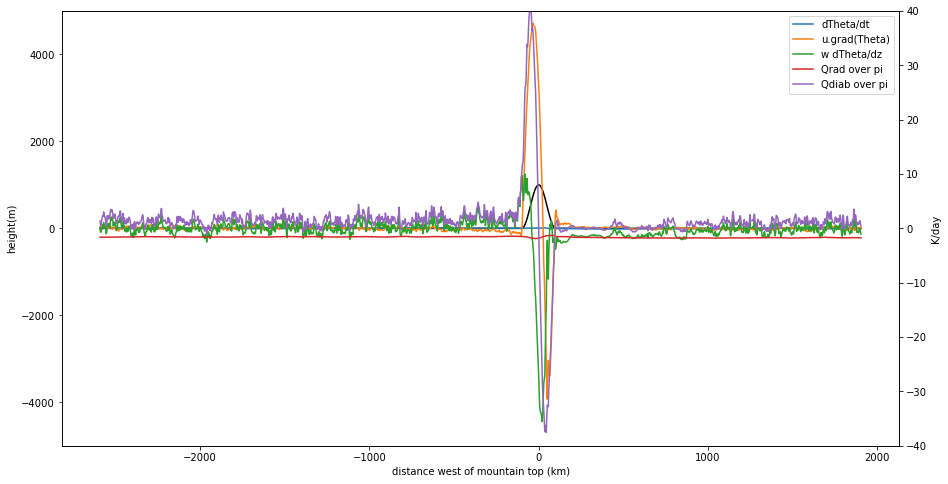

In [46]:
dist=(635-dThetadt.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-5000,5000)
ax.plot(dist,hgt[1000:2500],color='k')
ax2=ax.twinx()

ax2.set_ylabel("K/day")
ax2.plot(dist, plot1 ,label="dTheta/dt")
ax2.plot(dist, plot2 ,label="u.grad(Theta)")
ax2.plot(dist, plot3 ,label="w dTheta/dz")
ax2.plot(dist, plot4 ,label="Qrad over pi")
ax2.plot(dist, plot5 ,label="Qdiab over pi")
ax2.legend()
ax2.set_ylim(-40,40)

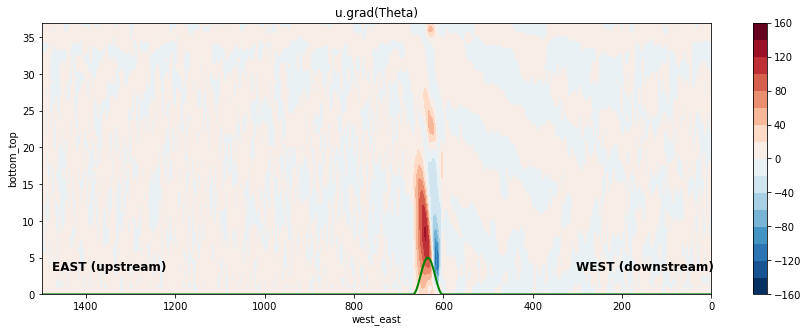

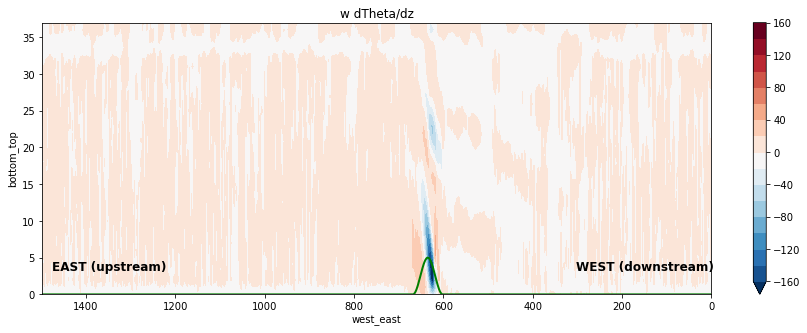

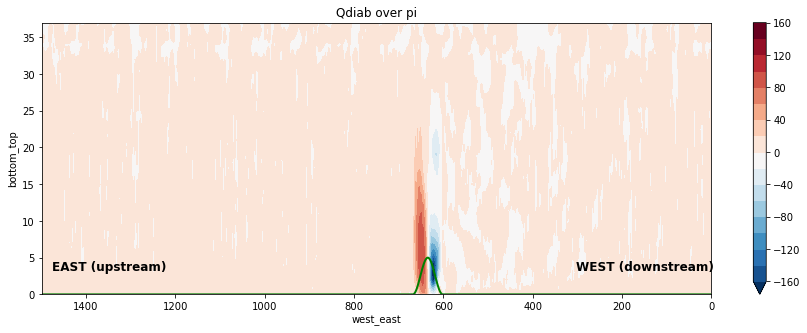

In [109]:
for var,lbl in zip([ugradTheta,wdThetadz ,Qdiab_pi  ],["u.grad(Theta)","w dTheta/dz","Qdiab over pi"]):
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    var.mean(['Time','south_north']).plot.contourf(ax=ax,xincrease=False,levels=np.arange(-160,161,20))
    ax.plot(var.west_east, hgt[1000:2500]/200,color='g',linewidth=2)
    add_text(ax)
    ax.set_title(lbl)


### Monthly means

In [23]:
%%time
# Advective term
meandThetadx = select(hrchannel.T).mean('Time').differentiate('west_east')/3000   # in K/meter
meandThetady = select(hrchannel.T).mean('Time').differentiate('south_north')/3000 # in K/meter
meandestag_U = wrf.destagger(select_stag(hrchannel.U).mean('Time'),2,meta=True)
meandestag_V = wrf.destagger(select(hrchannel.V).mean('Time'),1,meta=True)

meanugradTheta = ((meandestag_U*meandThetadx+meandestag_V*meandThetady)*86400).persist() #in K/day
meanudThetadx = ((meandestag_U*meandThetadx)*86400).persist() #in K/day
meanvdThetady = ((meandestag_V*meandThetady)*86400).persist() #in K/day


CPU times: user 9.61 s, sys: 21.6 s, total: 31.2 s
Wall time: 36.4 s


In [24]:
%%time
# Adiabatic term
meandestag_W = wrf.destagger(select_vstag(hrchannel.W).mean('Time'),0,meta=True)
dz = select_vstag(hrchannel.PHB).isel(Time=0).diff('bottom_top_stag').rename({'bottom_top_stag':'bottom_top'})/9.81
meandThetadz = select(hrchannel.T).mean('Time').differentiate('bottom_top')/dz

meanwdThetadz = (meandestag_W*meandThetadz*86400).persist() #in K/day

CPU times: user 4.01 s, sys: 7.45 s, total: 11.5 s
Wall time: 8.96 s


In [25]:
# Radiative heating term
meanQrad = select(hrchannel.RTHRATEN).mean('Time')*86400
meanQrad_pi = meanQrad/(hrchannel.PB[100,:,0,1000:2500]/1e5)**0.286

In [26]:
# diabatic heating term
meanQdiab_pi = meanugradTheta + meanwdThetadz - meanQrad

In [27]:
P_W = np.interp(hrchannel.ZNW.isel(Time=0)[::-1],hrchannel.ZNU.isel(Time=0)[::-1],hrchannel.PB[0,::-1,0,0])[::-1]
mass = xr.DataArray((P_W[:-1]-P_W[1:])/9.81,coords=hrchannel.PB[0,::-1,0,0].coords)
def dsmean2(ds):
    return (ds*mass).mean(['south_north','bottom_top'])/mass.mean()

In [29]:
%%time
meanplot2=dsmean2(meanugradTheta).load()
meanplot3=dsmean2(meanwdThetadz ).load()
meanplot4=dsmean2(meanQrad_pi   ).load()
meanplot5=dsmean2(meanQdiab_pi  ).load()

CPU times: user 4.32 s, sys: 14.2 s, total: 18.5 s
Wall time: 21.1 s


(-40.0, 40.0)

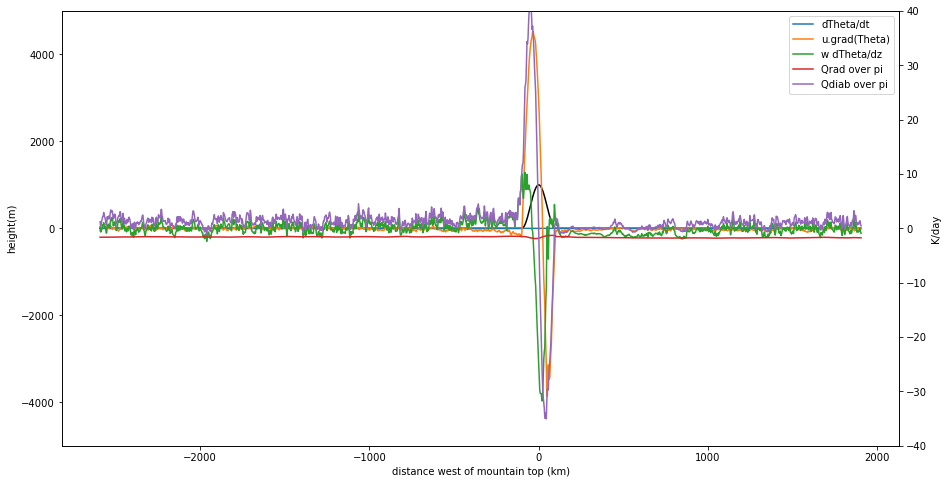

In [33]:
dist=(635-meanugradTheta.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-5000,5000)
ax.plot(dist,hgt[1000:2500],color='k')
ax2=ax.twinx()

ax2.set_ylabel("K/day")
ax2.plot(dist, [0.]*len(dist) ,label="dTheta/dt")
ax2.plot(dist, meanplot2 ,label="u.grad(Theta)")
ax2.plot(dist, meanplot3 ,label="w dTheta/dz")
ax2.plot(dist, meanplot4 ,label="Qrad over pi")
ax2.plot(dist, meanplot5 ,label="Qdiab over pi")
ax2.legend()
ax2.set_ylim(-40,40)

(-40.0, 40.0)

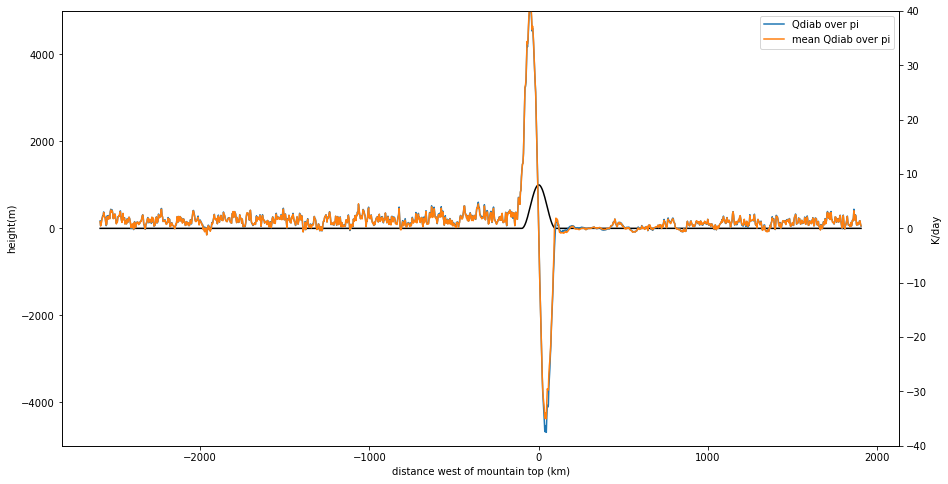

In [47]:
dist=(635-meanugradTheta.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-5000,5000)
ax.plot(dist,hgt[1000:2500],color='k')
ax2=ax.twinx()

ax2.set_ylabel("K/day")
ax2.plot(dist, plot5 ,label="Qdiab over pi")
ax2.plot(dist, meanplot5 ,label="mean Qdiab over pi")
ax2.legend()
ax2.set_ylim(-40,40)

## Hourly; with variables interpolated on pressure levels

In [39]:
def select_10days(ds):
    return ds.isel(num_press_levels_stag=slice(5,-4),Time=slice(1200,1440),west_east=slice(1000,2000))
def select_10days_6h(ds):
    return ds.isel(Time=slice(200,240),west_east=slice(1000,2000))

In [25]:
%%time
PPL=hrchannel_p.P_PL.isel(Time=0).load()[5:-4]
ThetaPL = (select_10days(hrchannel_p.T_PL)*(PPL/1e5)**(-0.286)).persist()

CPU times: user 1.15 s, sys: 14.7 s, total: 15.9 s
Wall time: 42.2 s


In [26]:
def compute_firstterms():
    UPL = select_10days(hrchannel_p.U_PL)
    VPL = select_10days(hrchannel_p.V_PL)
    WPL = select_10days(hrchannel_p.W_PL)
    RHOPL = select_10days(hrchannel_p.RHO_PL)
    
    # Tendency term
    dThetadt = ThetaPL.differentiate('Time')*4 #in K/day
    
    # Advective term
    dThetadx = ThetaPL.differentiate('west_east')/3000   # in K/meter
    dThetady = ThetaPL.differentiate('south_north')/3000 # in K/meter
    ugradTheta = ((UPL*dThetadx+VPL*dThetady)*86400) #in K/day

    # Adiabatic term
    omegadThetadp = (-9.81*RHOPL*WPL*ThetaPL.assign_coords({'pressure':PPL}).differentiate('pressure')*86400) #in K/day

    return dThetadt, ugradTheta, omegadThetadp

%time dThetadt, ugradTheta, omegadThetadp = compute_firstterms()

CPU times: user 44.6 ms, sys: 19.5 ms, total: 64.1 ms
Wall time: 62 ms


In [40]:
%%time
# Radiative heating term

#def interpolate_1H(ds):
#    ds = ds.swap_dims({'Time':'XTIME'}).resample(XTIME="1H").interpolate()
#    return ds.assign_coords(Time=('XTIME',range(len(ds.XTIME)))).swap_dims({'XTIME':'Time'})[:-1]

# Radiative heating term
meanQrad = select_10days_6h(hrchannel.RTHRATEN).mean('Time')*86400
meanQrad_pi = meanQrad/(hrchannel.PB[100,:,0,1000:2000]/1e5)**0.286

P_W = np.interp(hrchannel.ZNW.isel(Time=0)[::-1],hrchannel.ZNU.isel(Time=0)[::-1],hrchannel.PB[0,::-1,0,0])[::-1]
mass = xr.DataArray((P_W[:-1]-P_W[1:])/9.81,coords=hrchannel.PB[0,::-1,0,0].coords)
def dsmean2(ds):
    return (ds*mass).mean(['south_north','bottom_top'])/mass.mean()

avgQrad_pi = dsmean2(meanQrad_pi)

CPU times: user 596 ms, sys: 935 ms, total: 1.53 s
Wall time: 1.53 s


In [27]:
%%time
def dsmean3bis(ds):
    ds=ds.assign_coords({'pressure':PPL})
    return -ds.fillna(0.).mean(['south_north','Time']).integrate('pressure')/np.abs(ds.pressure[0]-ds.pressure[-1])
avgdThetadt     =dsmean3bis(dThetadt     ).load()
avgugradTheta   =dsmean3bis(ugradTheta   ).load()
avgomegadThetadp=dsmean3bis(omegadThetadp).load()

CPU times: user 20.8 s, sys: 1min 54s, total: 2min 15s
Wall time: 2min 16s


In [41]:
# diabatic heating term
avgQdiab_pi = avgdThetadt+avgugradTheta + avgomegadThetadp - avgQrad_pi

(-40.0, 40.0)

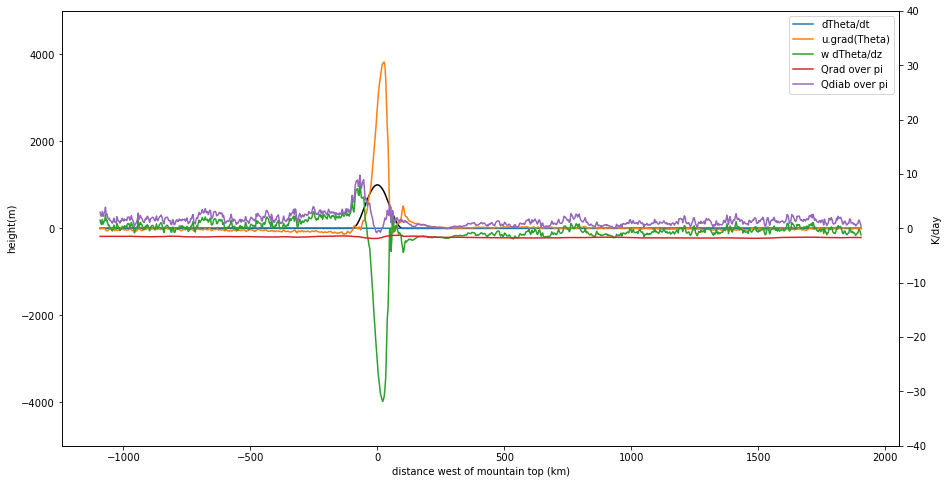

In [42]:
dist=(635-ugradTheta.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-5000,5000)
ax.plot(dist,hgt[1000:2000],color='k')
ax2=ax.twinx()

ax2.set_ylabel("K/day")
ax2.plot(dist, avgdThetadt      ,label="dTheta/dt")
ax2.plot(dist, avgugradTheta    ,label="u.grad(Theta)")
ax2.plot(dist, avgomegadThetadp ,label="w dTheta/dz")
ax2.plot(dist, avgQrad_pi       ,label="Qrad over pi")
ax2.plot(dist, avgQdiab_pi      ,label="Qdiab over pi")

ax2.legend()
ax2.set_ylim(-40,40)

(-40.0, 40.0)

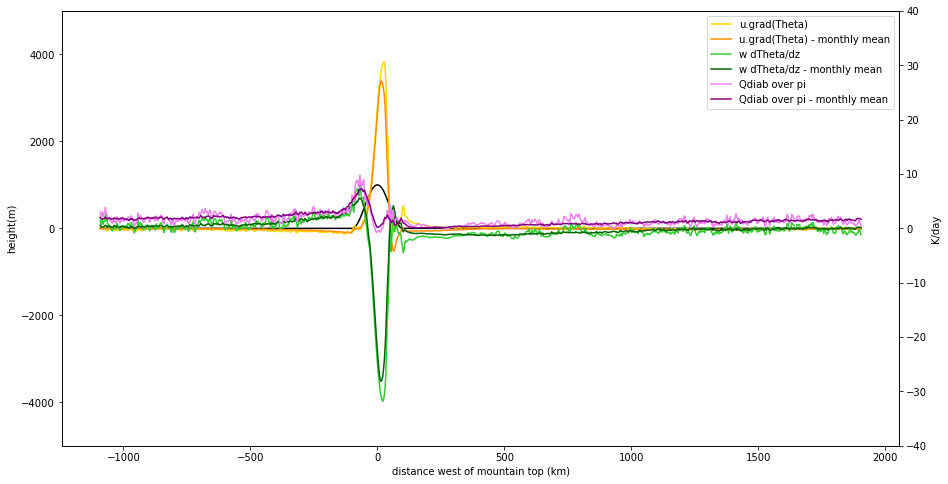

In [56]:
#Overlayed w/ monthly means
dist=(635-avgugradTheta.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-5000,5000)
ax.plot(dist,hgt[1000:2000],color='k')
ax2=ax.twinx()

ax2.set_ylabel("K/day")
ax2.plot(dist, avgugradTheta    ,label="u.grad(Theta)", color="gold")
ax2.plot(dist, meanplot2[:-500] ,label="u.grad(Theta) - monthly mean", color="darkorange")
ax2.plot(dist, avgomegadThetadp ,label="w dTheta/dz", color="limegreen")
ax2.plot(dist, meanplot3[:-500] ,label="w dTheta/dz - monthly mean", color="darkgreen")
ax2.plot(dist, avgQdiab_pi      ,label="Qdiab over pi", color="violet")
ax2.plot(dist, meanplot5[:-500] ,label="Qdiab over pi - monthly mean", color="purple")

ax2.legend()
ax2.set_ylim(-40,40)

## Monthly means; with variables interpolated on pressure levels

In [32]:
def select_lon(ds):
    return ds.isel(num_press_levels_stag=slice(5,-4),west_east=slice(1000,2500))

In [33]:
PPL=hrchannel_p.P_PL.isel(Time=0).load()
meanThetaPL = (tmean*(PPL/1e5)**(-0.286)).persist()

In [34]:
%%time
# Advective term
meandThetadx = select_lon(meanThetaPL).differentiate('west_east')/3000   # in K/meter
#meandThetady = select_lon(meanThetaPL).differentiate('south_north')/3000 # in K/meter

meanugradTheta = ((select_lon(umean)*meandThetadx)*86400).persist() #in K/day #+select_lon(vmean)*meandThetady


CPU times: user 2.52 ms, sys: 0 ns, total: 2.52 ms
Wall time: 2.14 ms


In [35]:
%%time
# Adiabatic term
meanomegadThetadp = (-9.81*select_lon(rhomean)*select_lon(wmean)*select_lon(meanThetaPL.assign_coords({'pressure':PPL})).differentiate('pressure')*86400).persist() #in K/day


CPU times: user 3.25 ms, sys: 0 ns, total: 3.25 ms
Wall time: 2.38 ms


In [43]:
# Radiative heating term
meanQrad = select_time(hrchannel.RTHRATEN).mean('Time')*86400
meanQrad_pi = meanQrad/(hrchannel.PB[100,:,0]/1e5)**0.286
meanQrad_pi=interp_pressure(meanQrad_pi).mean('south_north')[4:,1000:2500]

meanQrad_pi = xr.DataArray(np.array(meanQrad_pi),coords=meanomegadThetadp.coords)

In [44]:
# diabatic heating term
meanQdiab_pi = meanugradTheta + meanomegadThetadp - meanQrad_pi

In [45]:
def dsmean3(ds):
    ds=ds.assign_coords({'pressure':PPL[5:-4]})
    return -ds.fillna(0.).integrate('pressure')/np.abs(ds.pressure[0]-ds.pressure[-1])

In [117]:
print(PPL[5]-PPL[-4])

<xarray.DataArray 'P_PL' ()>
array(77500., dtype=float32)


In [46]:
%%time
meanplot2=dsmean3(meanugradTheta).load()
meanplot3=dsmean3(meanomegadThetadp ).load()
meanplot4=dsmean3(meanQrad_pi   ).load()
meanplot5=dsmean3(meanQdiab_pi  ).load()

CPU times: user 10.6 ms, sys: 0 ns, total: 10.6 ms
Wall time: 9.82 ms


(-40.0, 40.0)

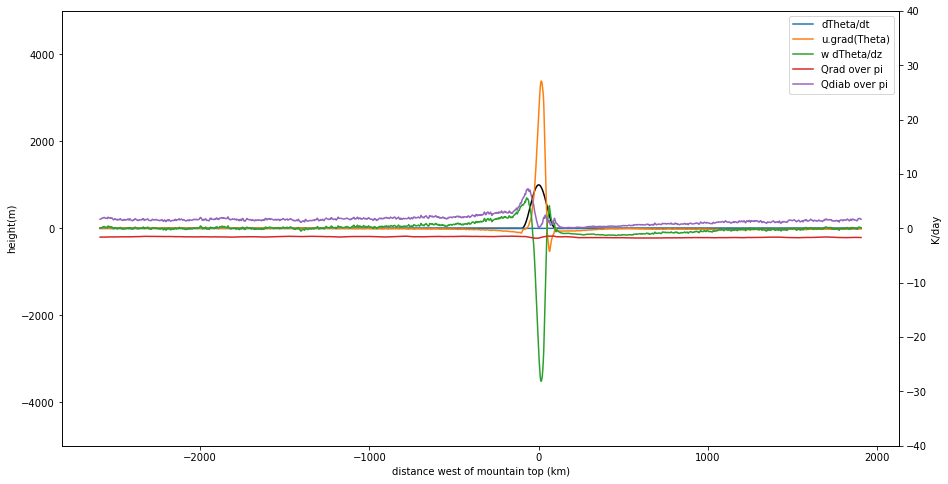

In [47]:
dist=(635-meanugradTheta.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-5000,5000)
ax.plot(dist,hgt[1000:2500],color='k')
ax2=ax.twinx()

ax2.set_ylabel("K/day")
ax2.plot(dist, [0.]*len(dist) ,label="dTheta/dt")
ax2.plot(dist, meanplot2 ,label="u.grad(Theta)")
ax2.plot(dist, meanplot3 ,label="w dTheta/dz")
ax2.plot(dist, meanplot4 ,label="Qrad over pi")
ax2.plot(dist, meanplot5 ,label="Qdiab over pi")

ax2.legend()
ax2.set_ylim(-40,40)

In [122]:
meanQdiab = meanQdiab_pi.assign_coords({'pressure':PPL[5:-4]})
meanQdiab = meanQdiab * (meanQdiab.pressure / 1e5)**0.286
meanQdiabbis = -meanQdiab.fillna(0.).integrate('pressure')/np.abs(meanQdiab.pressure[0]-meanQdiab.pressure[-1])

(-10.0, 30.0)

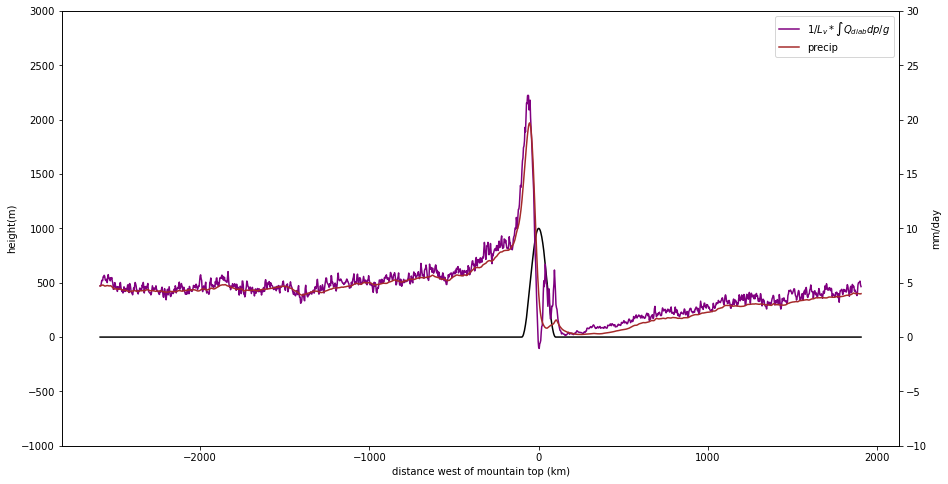

In [127]:
dist=(635-meanugradTheta.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-1000,3000)
ax.plot(dist,hgt[1000:2500],color='k')
ax2=ax.twinx()

ax2.set_ylabel("mm/day")
#ax2.plot(dist, [0.]*len(dist) ,label="dTheta/dt")
#ax2.plot(dist, meanplot2 ,label="u.grad(Theta)")
#ax2.plot(dist, meanplot3 ,label="w dTheta/dz")
#ax2.plot(dist, meanplot4 ,label="Qrad over pi")
ax2.plot(dist, meanQdiabbis*1004/2.26e6*77500/9.81 ,label="$1/L_v*\int Q_{diab} dp/g$",color="purple")
#ax2.axhline(meanplot5[1000:1500].mean() ,color="purple")
#ax2.axvline(0.,linestyle='dotted')
#ax2.axvline(-50.,linestyle='dotted')

ax2.plot(dist, hrchannelprecip[200:,:,1000:2500].mean(["Time","south_north"]) ,label="precip",color="brown")
#ax2.axhline(hrchannelprecip[200:,:,2000:2500].mean() ,color="brown")
ax2.legend()
ax2.set_ylim(-10,30)

### dqdt

In [57]:
PPL=hrchannel_p.P_PL.isel(Time=0).load()

In [92]:
%time PSFC = hrchannel.PSFC.isel(Time=slice(200,300),west_east=slice(1000,2500)).mean(["Time",'south_north']).load()

CPU times: user 70.9 ms, sys: 1.53 s, total: 1.6 s
Wall time: 4.37 s


In [94]:
%%time
# Hz advection term
meandqdx = select_lon(qmean).differentiate('west_east')/3000   # in 1/meter
meanugradq = ((select_lon(umean)*meandqdx)*86400).persist() #in 1/day #+select_lon(vmean)*meandThetady

# vertical advection term
meanomegadqdp = (-9.81*select_lon(rhomean)*select_lon(wmean)*select_lon(qmean.assign_coords({'pressure':PPL})).differentiate('pressure')*86400).persist() #in 1/day

# Evap
meanevap = hrchannel.QFX.isel(Time=slice(200,800)).mean(['south_north','Time'])[1000:2500]*86400/(PSFC/9.81) #in 1/day: the last term is the atmospheric column mass in kg/m^2 

CPU times: user 26.7 ms, sys: 0 ns, total: 26.7 ms
Wall time: 25.4 ms


In [103]:
%%time
meanplotdqdt=dsmean3(meanomegadqdp+meanugradq).load()-meanevap

CPU times: user 9.96 ms, sys: 0 ns, total: 9.96 ms
Wall time: 8.82 ms


In [100]:
def compute_dqdt():
    PPL=hrchannel_p.P_PL.isel(Time=0).load()[5:-4]
    QPL = select_10days(hrchannel_p.Q_PL).persist()
    UPL = select_10days(hrchannel_p.U_PL)
    VPL = select_10days(hrchannel_p.V_PL)
    WPL = select_10days(hrchannel_p.W_PL)
    RHOPL = select_10days(hrchannel_p.RHO_PL)
    
    # Tendency term
    dqdt = QPL.differentiate('Time')*4 #in K/day
    
    # Hz Advective term
    dqdx = QPL.differentiate('west_east')/3000   # in K/meter
    dqdy = QPL.differentiate('south_north')/3000 # in K/meter
    ugradq = ((UPL*dqdx+VPL*dqdy)*86400) #in K/day

    # V adv term
    omegadqdp = (-9.81*RHOPL*WPL*QPL.assign_coords({'pressure':PPL}).differentiate('pressure')*86400) #in K/day
    
    def dsmean3internal(ds):
        ds=ds.assign_coords({'pressure':PPL})
        return -ds.fillna(0.).mean(['south_north','Time']).integrate('pressure')/np.abs(ds.pressure[0]-ds.pressure[-1])

    return (dsmean3internal(dqdt) + dsmean3internal(ugradq) + dsmean3internal(omegadqdp)).load()

%time dqdt_hourly = compute_dqdt()

CPU times: user 27.2 s, sys: 2min 36s, total: 3min 3s
Wall time: 3min


(-40.0, 40.0)

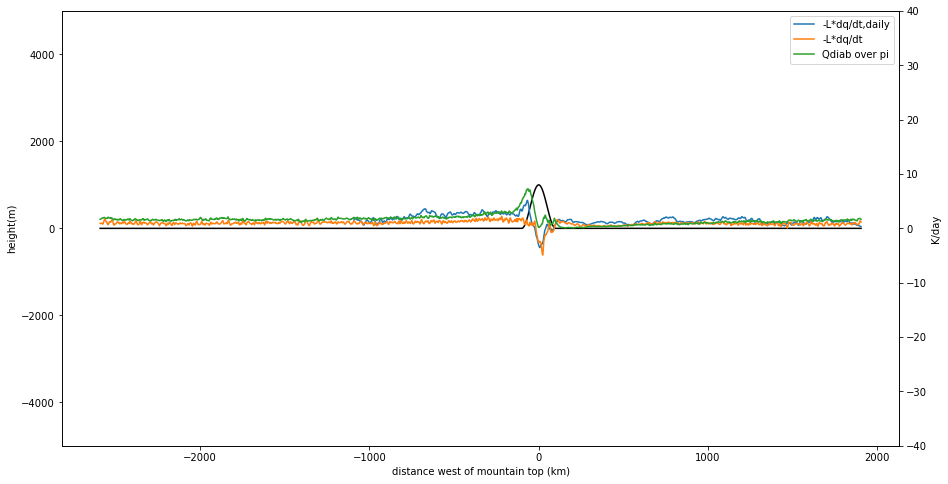

In [108]:
dist=(635-meanugradTheta.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-5000,5000)
ax.plot(dist,hgt[1000:2500],color='k')
ax2=ax.twinx()

ax2.set_ylabel("K/day")
ax2.plot(dist[:-500], np.convolve(-(dqdt_hourly-meanevap[:-500])*2.26e6/1004, np.ones(10)/10, mode='same') ,label="-L*dq/dt,daily")
ax2.plot(dist, -meanplotdqdt*2.26e6/1004 ,label="-L*dq/dt")
ax2.plot(dist, meanplot5 ,label="Qdiab over pi")

ax2.legend()
ax2.set_ylim(-40,40)

## Variables interpolated afterwards

In [209]:
%%time
# Advective term
meandThetadx = interp_pressure(select_time(hrchannel.T).mean('Time')).differentiate('west_east')/3000   # in K/meter
meandThetady = interp_pressure(select_time(hrchannel.T).mean('Time')).differentiate('south_north')/3000 # in K/meter
meandestag_U = interp_pressure(wrf.destagger(select_time(hrchannel.U).mean('Time'),2,meta=True))
meandestag_V = interp_pressure(wrf.destagger(select_time(hrchannel.V).mean('Time'),1,meta=True))

meanugradTheta = ((meandestag_U*meandThetadx+meandestag_V*meandThetady)*86400).persist() #in K/day
meanudThetadx = ((meandestag_U*meandThetadx)*86400).persist() #in K/day
meanvdThetady = ((meandestag_V*meandThetady)*86400).persist() #in K/day


CPU times: user 24.5 s, sys: 29.6 s, total: 54.1 s
Wall time: 54.3 s


In [210]:
%%time
# Adiabatic term
meandestag_W = interp_pressure(wrf.destagger(select_time(hrchannel.W).mean('Time'),0,meta=True))
meanRHO = interp_pressure(select_time(hrchannel.RHO).mean('Time'))
meandThetadp = interp_pressure(select_time(hrchannel.T).mean('Time')).differentiate('pressure')/100.

meanomegadThetadp = (-9.81*meanRHO*meandestag_W*meandThetadp*86400).persist() #in K/day

CPU times: user 18.3 s, sys: 28.7 s, total: 47.1 s
Wall time: 39.9 s


In [211]:
# diabatic heating term
meanQdiab_pi = meanugradTheta + meanomegadThetadp

In [230]:
def dsmean4(ds):
    return -ds.sel(west_east=slice(1000,2500)).fillna(0.).integrate('pressure').mean('south_north')/np.abs(ds.pressure[0]-ds.pressure[-1])

In [231]:
%%time
meanplot2=dsmean4(meanugradTheta).load()
meanplot3=dsmean4(meanomegadThetadp ).load()
meanplot5=dsmean4(meanQdiab_pi  ).load()

CPU times: user 75 ms, sys: 0 ns, total: 75 ms
Wall time: 73.3 ms


(-40.0, 40.0)

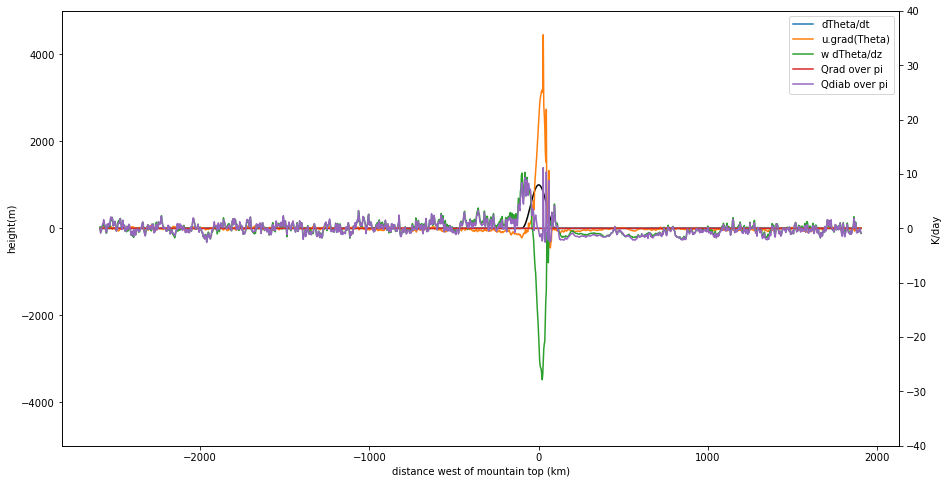

In [234]:
dist=(635-meanplot2.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-5000,5000)
ax.plot(dist,hgt[1000:2500],color='k')
ax2=ax.twinx()

ax2.set_ylabel("K/day")
ax2.plot(dist, [0.]*len(dist) ,label="dTheta/dt")
ax2.plot(dist, meanplot2 ,label="u.grad(Theta)")
ax2.plot(dist, meanplot3 ,label="w dTheta/dz")
ax2.plot(dist, [0.]*len(dist) ,label="Qrad over pi")
ax2.plot(dist, meanplot5 ,label="Qdiab over pi")
ax2.legend()
ax2.set_ylim(-40,40)

# Analytical theory

## Empirical M_s and M_h

In [213]:
Mh,Ms,Mq = M(channelwrf_p.Z_p.isel(pressure=slice(6,29),time=slice(400,1200)).mean(["time","south_north"]).load(),
             channelwrf_p.q_p.isel(pressure=slice(6,29),time=slice(400,1200)).mean(["time","south_north"]).load(),
             channelwrf_p.T_p.isel(pressure=slice(6,29),time=slice(400,1200)).mean(["time","south_north"]).load(),
             100*channelwrf_p.isel(pressure=slice(6,29),time=slice(400,1200)).pressure.load()
            )

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [32]:
def pressure_delta(column,pressure) :
    """given two arrays of the same length, return the pressure range corresponding to the non-nan values of column.
    e.g. if column = [nan,a,b,c,nan,nan] and pressure=[p1,p2,p3,p4,p5,p6], return p4-p2.
    Doesn't work if there are nans in the middle, eg. column = [nan,a,nan,c,nan,nan] (would still return p4-p2)"""
    
    idxs = np.where(~np.isnan(column))[0]
    try :
        return np.abs(pressure[idxs[0]]-pressure[idxs[-1]])
    except IndexError :
        print("Column only contains nans")
        return np.nan
def pressure_mean(da,vdim='pressure'):
    da_integ = da.fillna(0.).integrate(vdim)
    weights = xr.apply_ufunc(pressure_delta,da,da.pressure,input_core_dims=[[vdim],[vdim]],vectorize=True)#,dask="parallelized",output_dtypes=float)
    return da_integ/weights

In [33]:
from scipy.integrate import cumtrapz
def A_npy(T,p):
    """T temperature in Kelvin, p in pascal. p must be increasing"""
    assert p[0]<p[1]
    L = 2.26e6
    Cp=1004.
    Rv = 461.
    gamma = L*qsat(T,p/100.)/Rv/T**2 * L/Cp
    kappa=2/7
    bl = np.where(p>95000.)[0]
    freetrop = np.where(p<=95000.)[0]
    integ = 1/(1+gamma[freetrop])*np.exp(kappa*cumtrapz(1/(1+gamma[freetrop][::-1]),np.log(p[freetrop][::-1]),initial=0))[::-1]
    a = np.concatenate([integ,integ[-1]*(p[bl]/p[freetrop][-1])**kappa])
    return  a

def A_npy2(T,p):
    idxs = np.where(~np.isnan(T))[0]
    n=len(p)
    T=T[idxs]
    p=p[idxs]
    a = A_npy(T,p)
    return np.concatenate([[np.nan]*idxs[0] ,a,[np.nan]*(n-1-idxs[-1])])
def A(T,p):
    return xr.apply_ufunc(A_npy2,T,p,input_core_dims=[['pressure'],['pressure']],output_core_dims=[['pressure']],vectorize=True)
    

def Aplus_npy(T,p):
    idxs = np.where(~np.isnan(T))[0]
    n=len(p)
    T=T[idxs]
    p=p[idxs]
    a = A_npy(T,p)
    return np.concatenate([[np.nan]*idxs[0] ,-cumtrapz(a[::-1],np.log(p[::-1]),initial=0)[::-1],[np.nan]*(n-1-idxs[-1])])

def Omega_npy(T,p):
    aplus=Aplus_npy(T,p)
    aplushat = np.trapz(aplus,p)/(p[-1]-p[0])
    return cumtrapz(aplus[::-1]-aplushat,p[::-1],initial=0)[::-1]

def Aplus(T,p):
    return xr.apply_ufunc(Aplus_npy,T,p,input_core_dims=[['pressure'],['pressure']],output_core_dims=[['pressure']],vectorize=True)
    

def Omega(T,p):
    aplus=Aplus(T,p)
    aplushat = pressure_mean(aplus)
    return xr.apply_ufunc(lambda ap,aph,pp : cumtrapz(ap[::-1]-aph,pp[::-1],initial=0)[::-1],
                          aplus,aplushat,p,input_core_dims=[['pressure'],[],['pressure']],output_core_dims=[['pressure']],vectorize=True)

def M(Z,q,T,p):
    Lv = 2.26e6
    Cp = 1004.
    g=9.81
    aplus = Aplus(T,p)
    Mq = - pressure_mean(aplus*Lv*q)       + pressure_mean(aplus)*pressure_mean(Lv*q)
    Ms =   pressure_mean(aplus*(Cp*T+g*Z)) - pressure_mean(aplus)*pressure_mean(Cp*T+g*Z)
    return Ms-Mq,Ms,Mq

def Mss(Z,T,p):
    Cp = 1004.
    g=9.81
    aplus = Aplus(T,p)
    return pressure_mean(aplus*(Cp*T+g*Z)) - pressure_mean(aplus)*pressure_mean(Cp*T+g*Z)


In [28]:
def compute_msmh(i, slices=slices, plot=0,rol=0):
    s=slices[i][0]
    s0,s1 = 1635-s[0]//3,1635-s[1]//3
    
    Cp=1004.
    Lv=2.26e6
    g=9.81
    press=hrchannel_p.P_PL.isel(Time=-1).load()
    
    t     = tmean.isel(west_east=slice(s1,s0)).mean("west_east").persist().assign_coords({"pressure":press/100}).swap_dims({"num_press_levels_stag":"pressure"})[1:-4]
    z     = zmean.isel(west_east=slice(s1,s0)).mean("west_east").persist().assign_coords({"pressure":press/100}).swap_dims({"num_press_levels_stag":"pressure"})[1:-4]
    q     = qmean.isel(west_east=slice(s1,s0)).mean("west_east").persist().assign_coords({"pressure":press/100}).swap_dims({"num_press_levels_stag":"pressure"})[1:-4]
    if rol :
        omega = omegamean.rolling(west_east=101, center=True).mean().isel(west_east=slice(s1,s0)).mean("west_east").persist().assign_coords({"pressure":press/100}).swap_dims({"num_press_levels_stag":"pressure"})[1:-4]
    else :
        omega = omegamean.isel(west_east=slice(s1,s0)).mean("west_east").persist().assign_coords({"pressure":press/100}).swap_dims({"num_press_levels_stag":"pressure"})[1:-4]
    
    omega = omega/omega.mean()

    s = (Cp*t+g*z).load()
    h = (s + Lv*q).load()
    
    Ms=pressure_mean(omega*s.differentiate("pressure",edge_order=2)/100.)
    Mh=pressure_mean(omega*h.differentiate("pressure",edge_order=2)/100.)
    print(slices[i][1], "%.1f"%(Ms/Mh))
    
    if plot:
        _,ax=plt.subplots(1,1,figsize=(7,7))
        ax2=ax.twiny()
        ax.plot(omega/np.max(omega),omega.pressure, label="omega (rescaled)")
        #ax2.plot(s,omega.pressure, label="s",color='g')
        ax2.plot(h,omega.pressure, label="h",color='r')
        omegadsdp=omega*s.differentiate("pressure",edge_order=2)
        omegadhdp=omega*h.differentiate("pressure",edge_order=2)
        #ax.plot(-np.sign(omegadsdp.mean())*omegadsdp/omegadsdp.mean(),omega.pressure,color='limegreen', label="-omega*ds/dp (rescaled)")
        #ax.plot(-np.sign(omegadhdp.mean())*omegadhdp/omegadhdp.mean(),omega.pressure,color='orange', label="-omega*dh/dp (rescaled)")
        ax.plot(-omegadhdp/np.max(-omegadhdp),omega.pressure,color='orange', label="-omega*dh/dp (rescaled)")
        ax.set_ylim(1000,100)
        ax2.set_ylim(1000,100)
        ax.legend()
        ax2.legend()
        ax.axvline(0,linestyle='dotted',color='k')
        ax.set_title(slices[i][1])
    
    return Ms,Mh

In [29]:
slices2 = [((-4900,-4000),"(-4900,-4000)"),
           ((-4000,-3000),"(-4000,-3000)"),
           ((-3000,-2000),"(-3000,-2000)"),
           ((-2000,-1000),"(-2000,-1000)"),
           ((-1000,0),"(-1000,0)"),
           ((0,1000),"(0,1000)"),
           ((1000,2000),"(1000,2000)"),
           ((2000,3000),"(2000,3000)"),
           ((3000,4000),"(3000,4000)"),
           ((4000,4900),"(4000,4900)"),
          ]

slices3 = [((-4900,-2000),"(-4900,-2000)"),
           ((-2000,0),"(-2000,0)"),
           ((0,2000),"(0,2000)"),
           ((2000,4900),"(4000,4900)"),
          ]

(-4900,-2000) 4.0
(-2000,0) -1.8
(0,2000) -3.5
(4000,4900) 4.4


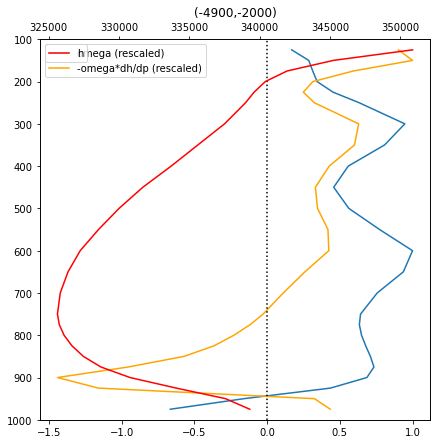

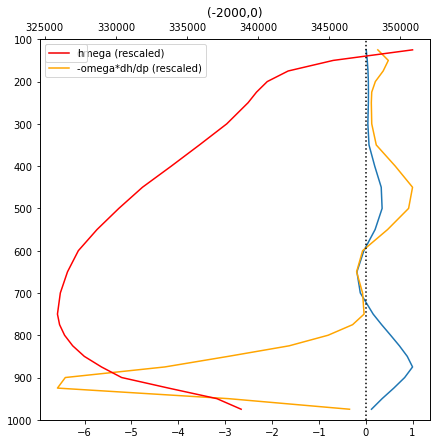

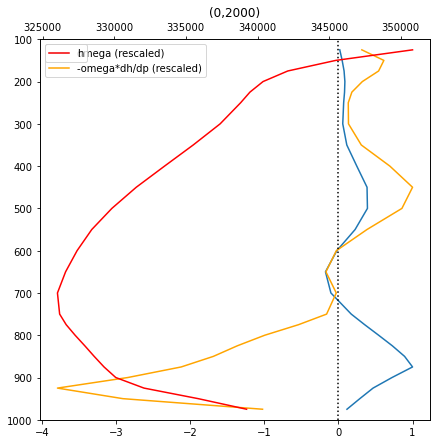

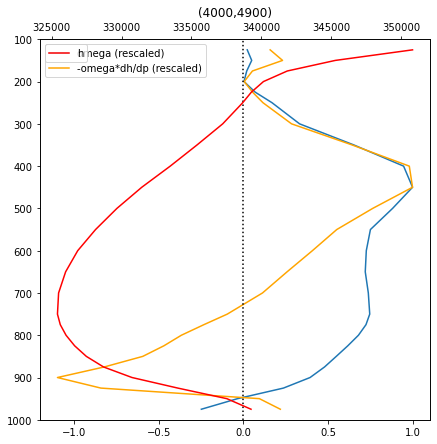

In [49]:
for i in range(len(slices3)):
    compute_msmh(i,slices3,1)

None

In [30]:
d=2000
bounds = [(max(-4900,i*d),min((i+1)*d,4900)) for i in range(-5000//d,5000//d+1)]
slices4 = [((l,r),"(%i,%i)"%(l,r)) for l,r in bounds]
distances = [(l+r)/2 for l,r in bounds]

(-4900,-4000) 2.4
(-4000,-2000) 4.7
(-2000,0) -1.8
(0,2000) -3.5
(2000,4000) 2.6
(4000,4900) -1.4


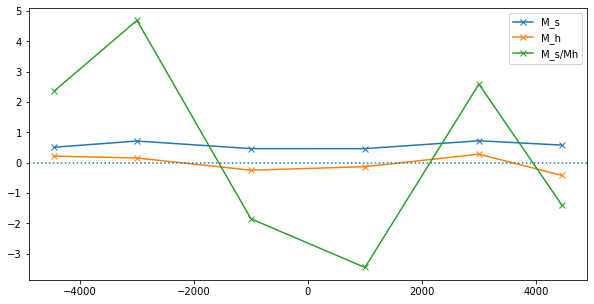

In [35]:
Mss = []
Mhs = []
for i in range(len(slices4)):
    Ms,Mh=compute_msmh(i,slices4,0,rol=0)
    Mss.append(Ms)
    Mhs.append(Mh)

Mss=np.array(Mss)
Mhs=np.array(Mhs)

_,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(distances, Mss,'-x',label="M_s")
ax.plot(distances, Mhs,'-x',label="M_h")
ax.plot(distances, Mss/Mhs,'-x',label="M_s/Mh")
ax.axhline(0,linestyle='dotted')
ax.legend()

(-4000,-2000) 4.7
(-2000,0) -1.8
(0,2000) -3.5
(2000,4000) 2.6
(4000,4900) -1.4


(<xarray.DataArray ()>
 array(0.57769084, dtype=float32),
 <xarray.DataArray ()>
 array(-0.41733938, dtype=float32))

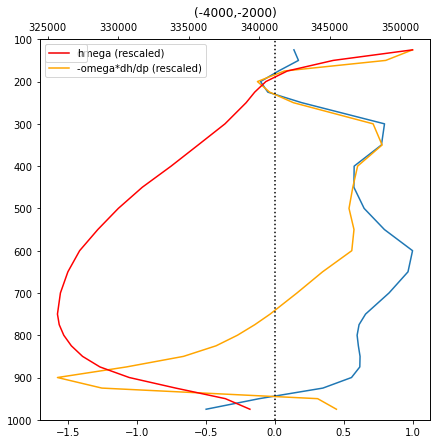

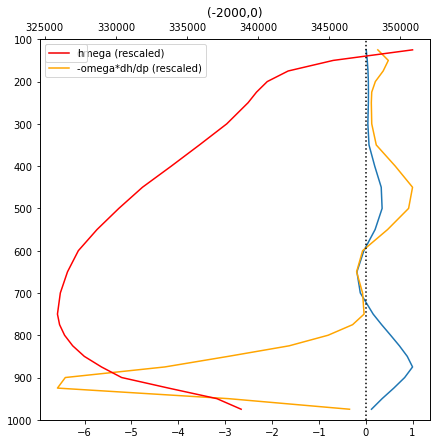

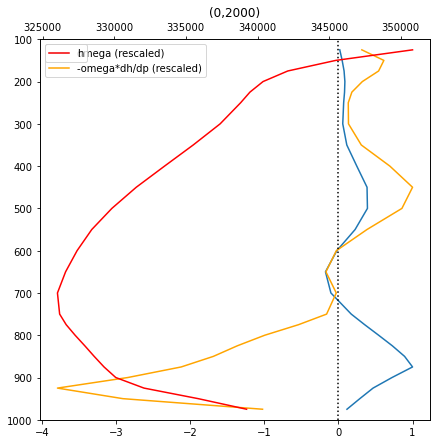

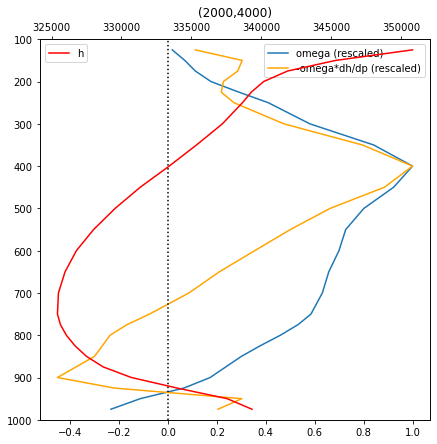

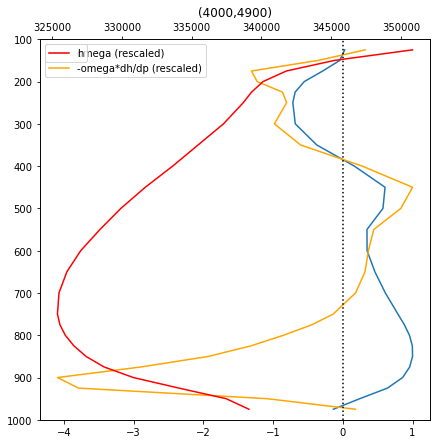

In [39]:
compute_msmh(1,slices4,1,rol=0)
compute_msmh(2,slices4,1,rol=0)
compute_msmh(3,slices4,1,rol=0)
compute_msmh(4,slices4,1,rol=0)
compute_msmh(5,slices4,1,rol=0)

In [43]:
n=101
sigma=5
gauss = np.exp(-np.linspace(-10,10,n)**2/(2*sigma**2))
gauss = gauss/np.sum(gauss)

In [44]:
wrol = w.rolling(west_east=n, center=True).mean()
#weight = xr.DataArray(gauss, dims=['window'])
#wrol=w.rolling(west_east=n, center=True).construct('window').dot(weight)

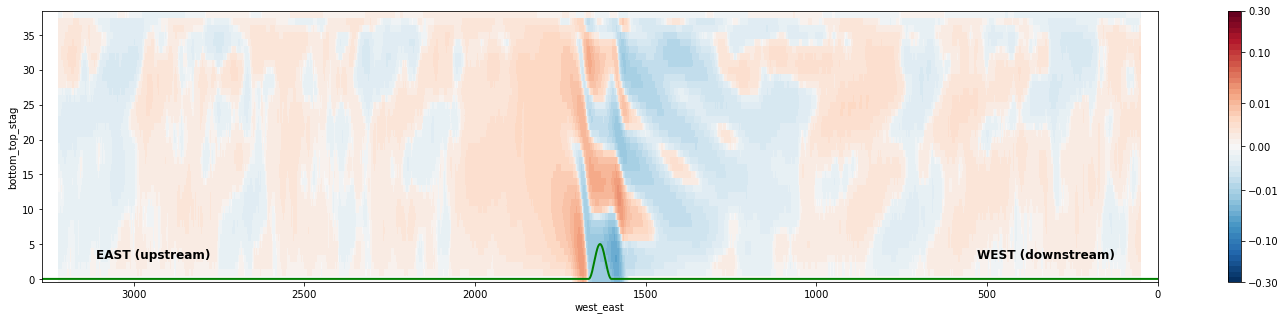

In [45]:
_,ax=plt.subplots(1,1,figsize=(25,5))
wrol.plot(ax=ax, x='west_east',xincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hrchannel.west_east, hgt[::-1]/200,color='g',linewidth=2)
add_text(ax)
#ax.set_title("Fully interactive high res simulation - W (nonlinear scale)")



In [371]:
Cp=1004.
Lv=2.26e6
g=9.81
press=hrchannel_p.P_PL.isel(Time=-1).load()

t     = tmean.assign_coords({"pressure":press/100}).swap_dims({"num_press_levels_stag":"pressure"})[1:-4]
z     = zmean.assign_coords({"pressure":press/100}).swap_dims({"num_press_levels_stag":"pressure"})[1:-4]
z=(z.fillna(0.)*0+z.isel(west_east=1740)).load()

q     = qmean.assign_coords({"pressure":press/100}).swap_dims({"num_press_levels_stag":"pressure"})[1:-4]
omega = omegamean.assign_coords({"pressure":press/100}).swap_dims({"num_press_levels_stag":"pressure"})[1:-4]
#omega = omega/pressure_mean(omega)

s = (Cp*t+g*z).load()
h = (s + Lv*q).load()


In [ ]:
weight = xr.DataArray(gauss, dims=['window'])
omegarol=omega.rolling(west_east=n, center=True).construct('window').dot(weight)
omegarol = omegarol/pressure_mean(omegarol)

In [ ]:
omega=omegarol
Ms=-pressure_mean(omega*s.differentiate("pressure",edge_order=2)/100.)
Mh=-pressure_mean(omega*h.differentiate("pressure",edge_order=2)/100.)

## Fit

In [30]:
from scipy.integrate import cumtrapz
def cape_analytical_Lx(x,f,L,CAPERCE,alpha):
    """Analytical solution to equation (3), with L and CAPERCE varying with x"""
    c = cumtrapz(1/(f*L),x,initial=0)
    return CAPERCE * np.exp(-c) * (1+cumtrapz(alpha/L*np.exp(c),x,initial=0))

def precip(cape,tau_c):
    """Compute a precipitation in mm/day (Pr = CAPE/tau_c/LatentHeat)"""
    Lc = 2.26e6 #latent heat of condensation in J/kg
    M = 8e3 #mass of troposphere in kg/m2
    conversion = 86400
    return conversion * M * cape / tau_c / Lc

In [43]:
a1hat=0.38
b1hat=0.45
tau_c0 = 2500
u_h = 10 #m/s
L = (a1hat+b1hat)/a1hat*u_h*tau_c0*8.5#float(Ms/Mh)

In [32]:
Evap = 4.4 #mm/day = kg/m2/day
Lv = 2.26e6 # J/kg
M=8000

Ehat = Lv*Evap/86400/M
CAPERCE = tau_c0*Ehat

In [33]:
print("L        = %.1f km"%(L/1000))
print("CAPE_RCE = %.1f J/kg"%CAPERCE)


L        = 928.3 km
CAPE_RCE = 71.9 J/kg


In [40]:
precip(CAPERCE,tau_c0)

4.4

In [21]:
# f from rule of thumb
x = 1000*(1635-hgt.west_east)*3 #+ 4902000
x = x[::-1] 
mtnheight = hgt.load().data
f = 1-0.999*(mtnheight/1000)

In [23]:
# f from simulation
cape=hrchannel_capecin[0].isel(Time=slice(200,400)).mean(['south_north','Time'])
pr = hrchannelprecip.isel(Time=slice(200,400)).mean(['south_north','Time'])
tauc=cape/(2.26e6*pr/86400/10000)
fsim = np.array(tauc[::-1]/tauc.isel(west_east=slice(2000,3000)).mean())

In [26]:
evap = hrchannel.QFX.isel(Time=slice(200,400)).mean(['south_north','Time'])
alpha = np.array(evap/evap.mean())[::-1]

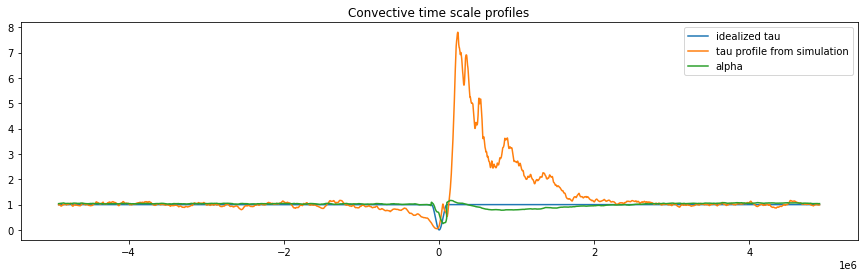

In [27]:
_,ax=plt.subplots(1,1,figsize=(15,4))
ax.plot(x,f,label="idealized tau")
ax.plot(x,fsim,label="tau profile from simulation")
ax.plot(x,alpha,label="alpha")
ax.set_title("Convective time scale profiles")
ax.legend()

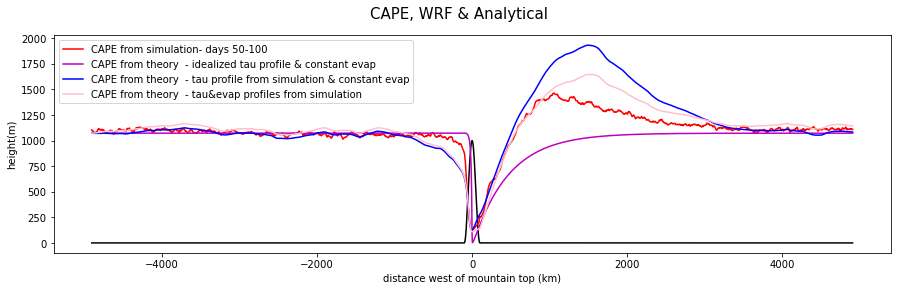

In [44]:
fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
dist=(1635-hgt.west_east)*3

ax.plot(dist,hgt,color='k')
ax.plot(dist ,hrchannel_capecin[0].isel(Time=slice(200,400)).mean(['south_north','Time']),label='CAPE from simulation- days 50-100',color='r')

fact=float(hrchannel_capecin[0].isel(Time=slice(200,400),west_east=slice(2000,3000)).mean()/CAPERCE)

ax.plot(dist,fact*cape_analytical_Lx(x,f,L,CAPERCE,1.)[::-1],color="m",label='CAPE from theory  - idealized tau profile & constant evap')
ax.plot(dist,fact*cape_analytical_Lx(x,fsim,L,CAPERCE,1.)[::-1],color="blue",label='CAPE from theory  - tau profile from simulation & constant evap')
ax.plot(dist,fact*cape_analytical_Lx(x,fsim,L,CAPERCE,alpha)[::-1],color="pink",label='CAPE from theory  - tau&evap profiles from simulation')

fig.suptitle("CAPE, WRF & Analytical", fontsize=15)
ax.legend()

# Making new input sounding for dry run

In [11]:
f = open(SCRATCH+'WRF/WRFV4_channelbis/test/em_beta_plane/input_sounding.backup', "r")
alllines=[]
l=[0]
while len(l)>0 :
    l=f.readline().split()
    alllines.append(l)
alllines = alllines[:-1]    

In [12]:
z = [float(l[0]) for l in alllines[1:]]

In [13]:
%%time
qbt = hrchannel.QVAPOR.isel(Time=slice(-40,-1),west_east=slice(2000,3000)).mean(['south_north','west_east','Time']).load()
Tbt = 300.+hrchannel.T.isel(Time=slice(-40,-1),west_east=slice(2000,3000)).mean(['south_north','west_east','Time']).load()
Zbts = 1/9.81*(hrchannel.PH+hrchannel.PHB).isel(Time=slice(-40,-1),west_east=slice(70,100)).mean(['south_north','west_east','Time']).load()
Zbt = np.interp(hrchannel.ZNU.isel(Time=0)[::-1],hrchannel.ZNW.isel(Time=0)[::-1],Zbts[::-1])[::-1]

CPU times: user 2.89 s, sys: 10.3 s, total: 13.2 s
Wall time: 22.5 s


In [14]:
q = np.interp(z,Zbt,qbt)
T = np.interp(z,Zbt,Tbt)

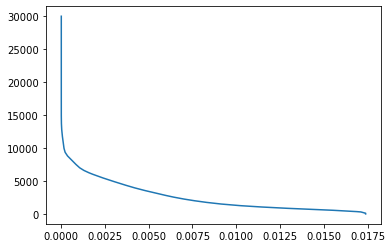

In [16]:
plt.plot(q,z)

In [18]:
i=0
f = open(SCRATCH+'WRF/WRFV4_channelbis/test/em_beta_plane/input_sounding', "w")
print('{:>10.2f}{:>10.2f}{:>10.2f}'.format(1000.,T[0],1000*q[0]),file=f)
for i,l in enumerate(alllines[1:]):
    print('{:>10.2f}{:>10.2f}{:>10.2f}{:>10.2f}{:>10.2f}'.format(z[i],T[i],1000*q[i],-10.,0.),file=f)
f.close()